In [1]:
#Importing Packages
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

import xgboost as xgb


We have two datasets for time series Analysis which is energy dataset and weather dataset.
Next step is to read energy dataset.csv file and set time as index

In [2]:
#df_energy = pd.read_csv('energy_dataset.csv',index_col=['time'])
df_energy = pd.read_csv('energy_dataset.csv')
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

From the above details the time is an object we need to convert this to datetime and set it as an index.
Used parse date and it didn't work.

In [3]:
df_energy.set_index('time', inplace=True)
df_energy.index = pd.to_datetime(df_energy.index, utc='True')
df_energy = df_energy.tz_localize(None) # tz_localize to remove the timezone
df_energy = df_energy[df_energy.index.year >=2015]
df_energy.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='time', length=35063, freq=None)

# Engery Dataset Cleaning

The next process is to eliminate columns that consist entirely of zeros, as they hold no utility. Furthermore, there are some irrelevant columns that need to be excluded from our analysis as they are wind, solar and total load forecast.

In [4]:
# Dropping columns that are enitrely zeros and other irrelevant ones

df_energy = df_energy.drop(['generation fossil coal-derived gas','generation fossil oil shale', 
                            'generation fossil peat', 'generation geothermal', 
                            'generation hydro pumped storage aggregated', 'generation marine', 
                            'generation wind offshore', 'forecast wind offshore eday ahead',
                            'total load forecast', 'forecast solar day ahead',
                            'forecast wind onshore day ahead'], 
                            axis=1)
df_energy.shape

(35063, 17)

In [5]:
df_energy.isnull().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

In [6]:
df_energy = df_energy.dropna(subset=['generation fossil oil', 'generation hydro pumped storage consumption',
                                     'generation hydro run-of-river and poundage','generation biomass',
                                     'generation waste','total load actual'])
df_energy.isnull().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

In [7]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35017 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 17 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35017 non-null  float64
 1   generation fossil brown coal/lignite         35017 non-null  float64
 2   generation fossil gas                        35017 non-null  float64
 3   generation fossil hard coal                  35017 non-null  float64
 4   generation fossil oil                        35017 non-null  float64
 5   generation hydro pumped storage consumption  35017 non-null  float64
 6   generation hydro run-of-river and poundage   35017 non-null  float64
 7   generation hydro water reservoir             35017 non-null  float64
 8   generation nuclear                           35017 non-null  float64
 9   generation other                     

Checking for duplicates in energy dataset

In [8]:
duplicates = df_energy.duplicated()
duplicate_rows = df_energy[duplicates]
print(duplicate_rows)

Empty DataFrame
Columns: [generation biomass, generation fossil brown coal/lignite, generation fossil gas, generation fossil hard coal, generation fossil oil, generation hydro pumped storage consumption, generation hydro run-of-river and poundage, generation hydro water reservoir, generation nuclear, generation other, generation other renewable, generation solar, generation waste, generation wind onshore, total load actual, price day ahead, price actual]
Index: []


In [9]:
df_energy.describe()

generation biomass  generation fossil brown coal/lignite  \
count        35017.000000                          35017.000000   
mean           383.526801                            448.119342   
std             85.304103                            354.612814   
min              0.000000                              0.000000   
25%            333.000000                              0.000000   
50%            367.000000                            509.000000   
75%            433.000000                            757.000000   
max            592.000000                            999.000000   

       generation fossil gas  generation fossil hard coal  \
count           35017.000000                 35017.000000   
mean             5622.518605                  4255.602479   
std              2202.071053                  1961.446031   
min                 0.000000                     0.000000   
25%              4126.000000                  2527.000000   
50%              4968.000000                  4473.000000   
75%              6429.000000                  5837.000000   
max             20034.000000                  8359.000000   

       generation fossil oil  generation hydro pumped storage consumption  \
count           35017.000000                                 35017.000000   
mean              298.337008                                   475.701773   
std                52.465665                                   792.554806   
min                 0.000000                                     0.000000   
25%               263.000000                                     0.000000   
50%               300.000000                                    68.000000   
75%               330.000000                                   616.000000   
max               449.000000                                  4523.000000   

       generation hydro run-of-river and poundage  \
count                                35017.000000   
mean                                   972.079533   
std                                    400.756996   
min                                      0.000000   
25%                                    637.000000   
50%                                    906.000000   
75%                                   1250.000000   
max                                   2000.000000   

       generation hydro water reservoir  generation nuclear  generation other  \
count                      35017.000000        35017.000000      35017.000000   
mean                        2604.511009         6263.998058         60.237599   
std                         1834.960358          838.274530         20.236155   
min                            0.000000            0.000000          0.000000   
25%                         1077.000000         5760.000000         53.000000   
50%                         2164.000000         6564.000000         57.000000   
75%                         3755.000000         7024.000000         80.000000   
max                         9728.000000         7117.000000        106.000000   

       generation other renewable  generation solar  generation waste  \
count                35017.000000      35017.000000      35017.000000   
mean                    85.651798       1433.093726        269.504241   
std                     14.063855       1680.330969         50.142420   
min                      0.000000          0.000000          0.000000   
25%                     74.000000         71.000000        240.000000   
50%                     88.000000        616.000000        279.000000   
75%                     97.000000       2579.000000        310.000000   
max                    119.000000       5792.000000        357.000000   

       generation wind onshore  total load actual  price day ahead  \
count             35017.000000       35017.000000     35017.000000   
mean               5466.030699       28696.928035        49.869399   
std                3213.623111        4574.204180        14.618346   
min          

There are no duplicates in the energy dataset.

Boxplot and Describe the dataset to find the statistics of data

<AxesSubplot: >

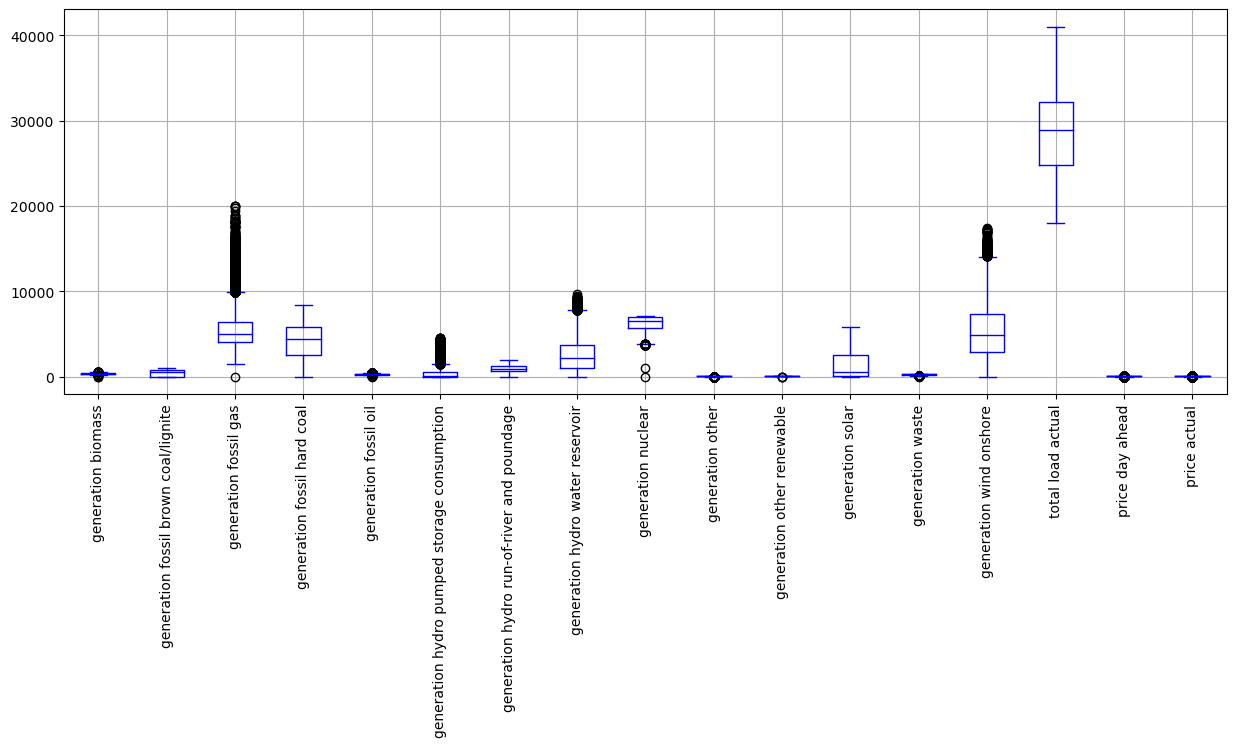

In [10]:
df_energy.boxplot(rot=90, color="blue",figsize=(15,5))

In [11]:
df_energy.describe().transpose()

count          mean  \
generation biomass                           35017.0    383.526801   
generation fossil brown coal/lignite         35017.0    448.119342   
generation fossil gas                        35017.0   5622.518605   
generation fossil hard coal                  35017.0   4255.602479   
generation fossil oil                        35017.0    298.337008   
generation hydro pumped storage consumption  35017.0    475.701773   
generation hydro run-of-river and poundage   35017.0    972.079533   
generation hydro water reservoir             35017.0   2604.511009   
generation nuclear                           35017.0   6263.998058   
generation other                             35017.0     60.237599   
generation other renewable                   35017.0     85.651798   
generation solar                             35017.0   1433.093726   
generation waste                             35017.0    269.504241   
generation wind onshore                      35017.0   5466.030699   
total load actual                            35017.0  28696.928035   
price day ahead                              35017.0     49.869399   
price actual                                 35017.0     57.887053   

                                                     std       min       25%  \
generation biomass                             85.304103      0.00    333.00   
generation fossil brown coal/lignite          354.612814      0.00      0.00   
generation fossil gas                        2202.071053      0.00   4126.00   
generation fossil hard coal                  1961.446031      0.00   2527.00   
generation fossil oil                          52.465665      0.00    263.00   
generation hydro pumped storage consumption   792.554806      0.00      0.00   
generation hydro run-of-river and poundage    400.756996      0.00    637.00   
generation hydro water reservoir             1834.960358      0.00   1077.00   
generation nuclear                            838.274530      0.00   5760.00   
generation other                               20.236155      0.00     53.00   
generation other renewable                     14.063855      0.00     74.00   
generation solar                             1680.330969      0.00     71.00   
generation waste                               50.142420      0.00    240.00   
generation wind onshore                      3213.623111      0.00   2935.00   
total load actual                            4574.204180  18041.00  24808.00   
price day ahead                                14.618346      2.06     41.49   
price actual                                   14.190227      9.33     49.36   

                                                  50%       75%       max  
generation biomass                             367.00    433.00    592.00  
generation fossil brown coal/lignite           509.00    757.00    999.00  
generation fossil gas                         4968.00   6429.00  20034.00  
generation fossil hard coal                   4473.00   5837.00   8359.00  
generation fossil oil                          300.00    330.00    449.00  
generation hydro pumped storage consumption     68.00    616.00   4523.00  
generation hydro run-of-river and poundage     906.00   1250.00   2000.00  
generation hydro water reservoir              2164.00   3755.00   9728.00  
generation nuclear                            6564.00   7024.00   7117.00  
generation other                                57.00     80.00    106.00  
generation other renewable                      88.00     97.00    119.00  
generation solar                               616.00   2579.00   5792.00  
generation waste                               279.00    310.00    357.00  
generation wind onshore                       4850.00   7399.00  17436.00  
total load actual                            28902.00  32192.00  41015.00  
price day ahead                                 50.52     60.53    101.99  
price actual                                    58.02

Sorting the values in ascending order based on mean values

In [12]:
df_energy.describe().transpose().sort_values(by='mean', ascending=False)

count          mean  \
total load actual                            35017.0  28696.928035   
generation nuclear                           35017.0   6263.998058   
generation fossil gas                        35017.0   5622.518605   
generation wind onshore                      35017.0   5466.030699   
generation fossil hard coal                  35017.0   4255.602479   
generation hydro water reservoir             35017.0   2604.511009   
generation solar                             35017.0   1433.093726   
generation hydro run-of-river and poundage   35017.0    972.079533   
generation hydro pumped storage consumption  35017.0    475.701773   
generation fossil brown coal/lignite         35017.0    448.119342   
generation biomass                           35017.0    383.526801   
generation fossil oil                        35017.0    298.337008   
generation waste                             35017.0    269.504241   
generation other renewable                   35017.0     85.651798   
generation other                             35017.0     60.237599   
price actual                                 35017.0     57.887053   
price day ahead                              35017.0     49.869399   

                                                     std       min       25%  \
total load actual                            4574.204180  18041.00  24808.00   
generation nuclear                            838.274530      0.00   5760.00   
generation fossil gas                        2202.071053      0.00   4126.00   
generation wind onshore                      3213.623111      0.00   2935.00   
generation fossil hard coal                  1961.446031      0.00   2527.00   
generation hydro water reservoir             1834.960358      0.00   1077.00   
generation solar                             1680.330969      0.00     71.00   
generation hydro run-of-river and poundage    400.756996      0.00    637.00   
generation hydro pumped storage consumption   792.554806      0.00      0.00   
generation fossil brown coal/lignite          354.612814      0.00      0.00   
generation biomass                             85.304103      0.00    333.00   
generation fossil oil                          52.465665      0.00    263.00   
generation waste                               50.142420      0.00    240.00   
generation other renewable                     14.063855      0.00     74.00   
generation other                               20.236155      0.00     53.00   
price actual                                   14.190227      9.33     49.36   
price day ahead                                14.618346      2.06     41.49   

                                                  50%       75%       max  
total load actual                            28902.00  32192.00  41015.00  
generation nuclear                            6564.00   7024.00   7117.00  
generation fossil gas                         4968.00   6429.00  20034.00  
generation wind onshore                       4850.00   7399.00  17436.00  
generation fossil hard coal                   4473.00   5837.00   8359.00  
generation hydro water reservoir              2164.00   3755.00   9728.00  
generation solar                               616.00   2579.00   5792.00  
generation hydro run-of-river and poundage     906.00   1250.00   2000.00  
generation hydro pumped storage consumption     68.00    616.00   4523.00  
generation fossil brown coal/lignite           509.00    757.00    999.00  
generation biomass                             367.00    433.00    592.00  
generation fossil oil                          300.00    330.00    449.00  
generation waste                               279.00    310.00    357.00  
generation other renewable                      88.00     97.00    119.00  
generation other                                57.00     80.00    106.00  
price actual                                    58.02     68.00    116.80  
price day ahead                                 50.52

The major contributions of energy soruces are nuclear, fossil gas, wind, hydro-water, solar

Find out the percentage of generated energy by each source on total enegry generation

For that we need to add a column total energy generation as the aggregate of all the energy sources

In [13]:
df_energy['total generation'] = df_energy['generation nuclear']+df_energy['generation fossil gas']+df_energy['generation wind onshore']+\
                                df_energy['generation fossil hard coal']+df_energy['generation hydro water reservoir']+df_energy['generation solar']+df_energy['generation hydro run-of-river and poundage']+\
                                df_energy['generation hydro pumped storage consumption']+df_energy['generation fossil brown coal/lignite']+df_energy['generation biomass']+df_energy['generation biomass']+\
                                df_energy['generation waste']+df_energy['generation other renewable']+df_energy['generation other']

In [14]:
df_energy.describe().transpose().sort_values(by='mean', ascending=False)

count          mean  \
total generation                             35017.0  28724.102465   
total load actual                            35017.0  28696.928035   
generation nuclear                           35017.0   6263.998058   
generation fossil gas                        35017.0   5622.518605   
generation wind onshore                      35017.0   5466.030699   
generation fossil hard coal                  35017.0   4255.602479   
generation hydro water reservoir             35017.0   2604.511009   
generation solar                             35017.0   1433.093726   
generation hydro run-of-river and poundage   35017.0    972.079533   
generation hydro pumped storage consumption  35017.0    475.701773   
generation fossil brown coal/lignite         35017.0    448.119342   
generation biomass                           35017.0    383.526801   
generation fossil oil                        35017.0    298.337008   
generation waste                             35017.0    269.504241   
generation other renewable                   35017.0     85.651798   
generation other                             35017.0     60.237599   
price actual                                 35017.0     57.887053   
price day ahead                              35017.0     49.869399   

                                                     std       min       25%  \
total generation                             4173.273497   6899.00  25539.00   
total load actual                            4574.204180  18041.00  24808.00   
generation nuclear                            838.274530      0.00   5760.00   
generation fossil gas                        2202.071053      0.00   4126.00   
generation wind onshore                      3213.623111      0.00   2935.00   
generation fossil hard coal                  1961.446031      0.00   2527.00   
generation hydro water reservoir             1834.960358      0.00   1077.00   
generation solar                             1680.330969      0.00     71.00   
generation hydro run-of-river and poundage    400.756996      0.00    637.00   
generation hydro pumped storage consumption   792.554806      0.00      0.00   
generation fossil brown coal/lignite          354.612814      0.00      0.00   
generation biomass                             85.304103      0.00    333.00   
generation fossil oil                          52.465665      0.00    263.00   
generation waste                               50.142420      0.00    240.00   
generation other renewable                     14.063855      0.00     74.00   
generation other                               20.236155      0.00     53.00   
price actual                                   14.190227      9.33     49.36   
price day ahead                                14.618346      2.06     41.49   

                                                  50%       75%       max  
total generation                             28544.00  31646.00  42330.00  
total load actual                            28902.00  32192.00  41015.00  
generation nuclear                            6564.00   7024.00   7117.00  
generation fossil gas                         4968.00   6429.00  20034.00  
generation wind onshore                       4850.00   7399.00  17436.00  
generation fossil hard coal                   4473.00   5837.00   8359.00  
generation hydro water reservoir              2164.00   3755.00   9728.00  
generation solar                               616.00   2579.00   5792.00  
generation hydro run-of-river and poundage     906.00   1250.00   2000.00  
generation hydro pumped storage consumption     68.00    616.00   4523.00  
generation fossil brown coal/lignite           509.00    757.00    999.00  
generation biomass                             367.00    433.00    592.00  
generation fossil oil                          300.00    330.00    449.00  
generation waste                               279.00    310.00    357.00  
generation other renewable                      88.00  

Total Power Generated over the 4 years from various source

In [15]:
print('Total Power Generated over the 4 years from various source ')
print()
print("generation nuclear                         ",round((df_energy['generation nuclear'].sum()/df_energy['total generation'].sum())*100,1),'%')
print("generation fossil gas                      ",round((df_energy['generation fossil gas'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation wind onshore                    ',round((df_energy['generation wind onshore'].sum()/df_energy['total generation'].sum())*100,1),'%')
print("generation fossil hard coal                ",round((df_energy['generation fossil hard coal'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro water reservoir            ',round((df_energy['generation hydro water reservoir'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation solar                            ',round((df_energy['generation solar'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro run-of-river and poundage  ',round((df_energy['generation hydro run-of-river and poundage'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation hydro pumped storage consumption ',round((df_energy['generation hydro pumped storage consumption'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation waste                            ',round((df_energy['generation waste'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation other renewable                  ',round((df_energy['generation other renewable'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation other                            ',round((df_energy['generation other'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation fossil oil                       ',round((df_energy['generation fossil oil'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation biomass                          ',round((df_energy['generation biomass'].sum()/df_energy['total generation'].sum())*100,1),'%')
print('generation fossil brown coal/lignite        ',round((df_energy['generation fossil brown coal/lignite'].sum()/df_energy['total generation'].sum())*100,1),'%')

Total Power Generated over the 4 years from various source 

generation nuclear                          21.8 %
generation fossil gas                       19.6 %
generation wind onshore                     19.0 %
generation fossil hard coal                 14.8 %
generation hydro water reservoir             9.1 %
generation solar                             5.0 %
generation hydro run-of-river and poundage   3.4 %
generation hydro pumped storage consumption  1.7 %
generation waste                             0.9 %
generation other renewable                   0.3 %
generation other                             0.2 %
generation fossil oil                        1.0 %
generation biomass                           1.3 %
generation fossil brown coal/lignite         1.6 %


Visualization of the percentage of energy generation by different sources resampled monthly

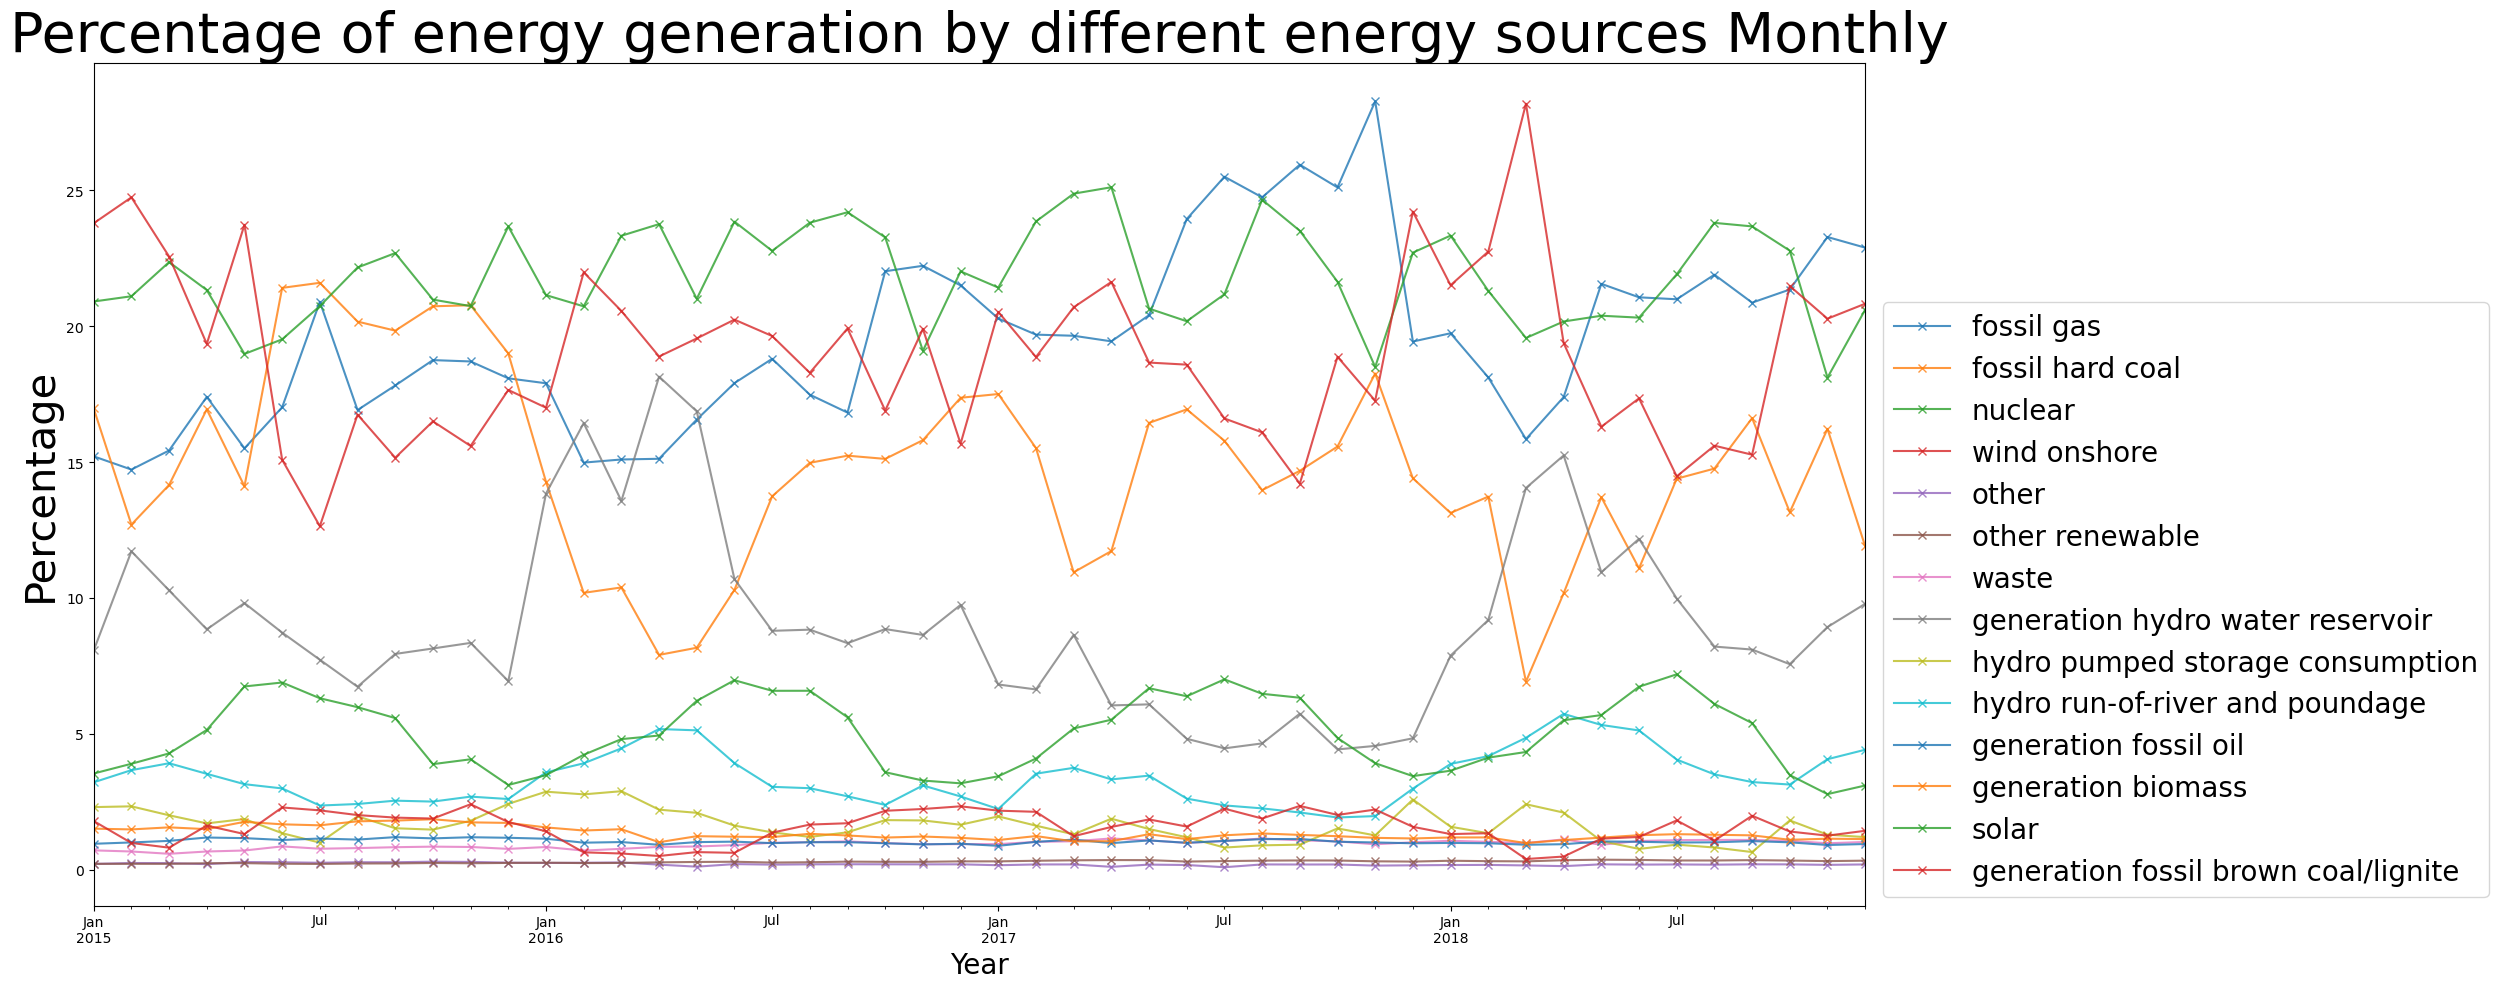

In [16]:
axes = df_energy['generation fossil gas'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='fossil gas')
axes = df_energy['generation fossil hard coal'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='fossil hard coal')
axes = df_energy['generation nuclear'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='nuclear')
axes = df_energy['generation wind onshore'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='wind onshore')


axes = df_energy['generation other'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='other')
axes = df_energy['generation other renewable'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='other renewable')
axes = df_energy['generation waste'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='waste')
axes = df_energy['generation hydro water reservoir'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='generation hydro water reservoir')
axes = df_energy['generation hydro pumped storage consumption'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='hydro pumped storage consumption')
axes = df_energy['generation hydro run-of-river and poundage'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='hydro run-of-river and poundage')
axes = df_energy['generation fossil oil'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='generation fossil oil')
axes = df_energy['generation biomass'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='generation biomass')
axes = df_energy['generation solar'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='solar')
axes = df_energy['generation fossil brown coal/lignite'].resample("M").mean().div(df_energy['total generation'].resample("M").mean()).multiply(100).plot(marker='x', alpha=0.8,  figsize=(25,10), label='generation fossil brown coal/lignite')

axes.legend(loc='upper right', frameon=False, fontsize=15)
axes.set_title('Percentage of energy generation by different energy sources Monthly', fontsize=40)
axes.set_ylabel('Percentage', fontsize=30)
axes.set_xlabel("Year", fontsize=20)
axes.legend(loc=(1.01, .01), ncol=1, fontsize=20)
plt.tight_layout()

# Weather Feature Dataset Cleaning and Preprocessing
Read Weather Feature dataset.csv and set time as index

In [17]:
df_weather = pd.read_csv('weather_features.csv',index_col=['dt_iso'])
#df_weather = pd.read_csv('weather_features.csv')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178396 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   city_name            178396 non-null  object 
 1   temp                 178396 non-null  float64
 2   temp_min             178396 non-null  float64
 3   temp_max             178396 non-null  float64
 4   pressure             178396 non-null  int64  
 5   humidity             178396 non-null  int64  
 6   wind_speed           178396 non-null  int64  
 7   wind_deg             178396 non-null  int64  
 8   rain_1h              178396 non-null  float64
 9   rain_3h              178396 non-null  float64
 10  snow_3h              178396 non-null  float64
 11  clouds_all           178396 non-null  int64  
 12  weather_id           178396 non-null  int64  
 13  weather_main         178396 non-null  object 
 14  weather_description  178396 no

From the above details the dt_iso is an object we need to convert this to datetime and set it as an index.
Used parse date and it didn't work.

In [18]:
#df_weather.set_index('dt_iso', inplace=True)
df_weather.index = pd.to_datetime(df_weather.index, utc='True')
df_weather = df_weather.tz_localize(None) #tz_localoze to remove the timezone
df_weather = df_weather[df_weather.index.year >=2015]
df_weather.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2018-12-31 13:00:00', '2018-12-31 14:00:00',
               '2018-12-31 15:00:00', '2018-12-31 16:00:00',
               '2018-12-31 17:00:00', '2018-12-31 18:00:00',
               '2018-12-31 19:00:00', '2018-12-31 20:00:00',
               '2018-12-31 21:00:00', '2018-12-31 22:00:00'],
              dtype='datetime64[ns]', name='dt_iso', length=178391, freq=None)

Next step is to identify if any null values exists

In [19]:
df_weather.isna().sum()

city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [20]:
df_weather.head()

city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                 
2015-01-01 00:00:00  Valencia  270.475   270.475   270.475      1001   
2015-01-01 01:00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 02:00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 03:00:00  Valencia  269.686   269.686   269.686      1002   
2015-01-01 04:00:00  Valencia  270.292   270.292   270.292      1004   

                     humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
dt_iso                                                                  
2015-01-01 00:00:00        77           1        62      0.0      0.0   
2015-01-01 01:00:00        78           0        23      0.0      0.0   
2015-01-01 02:00:00        78           0        23      0.0      0.0   
2015-01-01 03:00:00        78           0        23      0.0      0.0   
2015-01-01 04:00:00        71           2       321      0.0      0.0   

                     snow_3h  clouds_all  weather_id weather_main  \
dt_iso                                                              
2015-01-01 00:00:00      0.0           0         800        clear   
2015-01-01 01:00:00      0.0           0         800        clear   
2015-01-01 02:00:00      0.0           0         800        clear   
2015-01-01 03:00:00      0.0           0         800        clear   
2015-01-01 04:00:00      0.0           0         800        clear   

                    weather_description weather_icon  
dt_iso                                                
2015-01-01 00:00:00        sky is clear          01n  
2015-01-01 01:00:00        sky is clear          01n  
2015-01-01 02:00:00        sky is clear          01n  
2015-01-01 03:00:00        sky is clear          01n  
2015-01-01 04:00:00        sky is clear          01n

From this data we can find that rain_1h and rain_3h which are rain for 1 hour and rain for 3 hours the purpose is same, also weather_id, weather_description, Weather_icon is of no use for our analysis.

In [21]:
df_weather.drop(columns = [ 'rain_3h','weather_id','weather_description', 'weather_icon' ],axis=1, inplace=True)
df_weather.shape

(178391, 12)

In [22]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178391 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city_name     178391 non-null  object 
 1   temp          178391 non-null  float64
 2   temp_min      178391 non-null  float64
 3   temp_max      178391 non-null  float64
 4   pressure      178391 non-null  int64  
 5   humidity      178391 non-null  int64  
 6   wind_speed    178391 non-null  int64  
 7   wind_deg      178391 non-null  int64  
 8   rain_1h       178391 non-null  float64
 9   snow_3h       178391 non-null  float64
 10  clouds_all    178391 non-null  int64  
 11  weather_main  178391 non-null  object 
dtypes: float64(5), int64(5), object(2)
memory usage: 17.7+ MB


Converting datatypes of the weather variables to float64 as some of them are int64

In [23]:
columns_to_convert = ['pressure', 'humidity', 'wind_speed','wind_deg','clouds_all']
df_weather[columns_to_convert] = df_weather[columns_to_convert].astype(float)

In [24]:
df_weather.info()
# All the datatypes for numerical columns are now float64

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178391 entries, 2015-01-01 00:00:00 to 2018-12-31 22:00:00
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city_name     178391 non-null  object 
 1   temp          178391 non-null  float64
 2   temp_min      178391 non-null  float64
 3   temp_max      178391 non-null  float64
 4   pressure      178391 non-null  float64
 5   humidity      178391 non-null  float64
 6   wind_speed    178391 non-null  float64
 7   wind_deg      178391 non-null  float64
 8   rain_1h       178391 non-null  float64
 9   snow_3h       178391 non-null  float64
 10  clouds_all    178391 non-null  float64
 11  weather_main  178391 non-null  object 
dtypes: float64(10), object(2)
memory usage: 17.7+ MB


In [25]:
df_weather.shape

(178391, 12)

Checking for duplicates in Weather dataset

In [26]:
df_weather.index.has_duplicates

True

In [27]:
# Dropping the duplicates keeping the first
df_weather = df_weather.drop_duplicates(keep='first')
df_weather.shape

(168456, 12)

It was 178396 rows and after dropping duplicates it is now 168457 rows , 0.05% of total rows are dropped

<AxesSubplot: xlabel='city_name'>

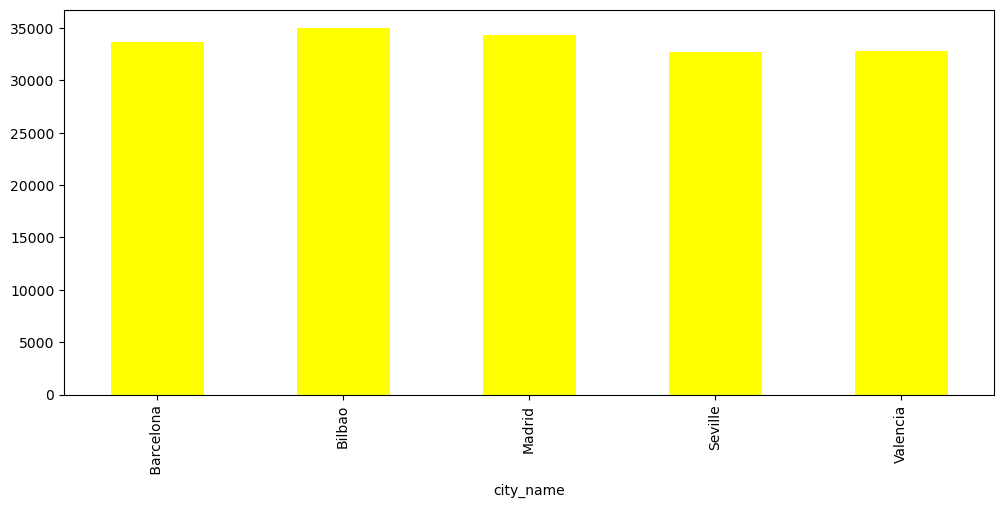

In [28]:
#Plotting the temperature records for cities
df_weather.groupby(["city_name"])[['temp']].count().plot.bar(color="yellow", legend=False, figsize=(12,5))
#This look almost similiar for all cities

Identifying outliers in Weather dataset

In [29]:
df_weather.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  168456.00  168456.00  168456.00   168456.00  168456.00   168456.00   
mean      289.65     288.29     291.20     1073.12      68.10        2.49   
std         8.02       7.94       8.63     6143.21      21.85        2.11   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.25     284.82     1014.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.71     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    snow_3h  clouds_all  
count  168456.00  168456.00  168456.00   168456.00  
mean      166.93       0.08       0.01       25.19  
std       116.97       0.41       0.23       30.66  
min         0.00       0.00       0.00        0.00  
25%        55.00       0.00       0.00        0.00  
50%       180.00       0.00       0.00       20.00  
75%       270.00       0.00       0.00       40.00  
max       360.00      12.00      21.50      100.00

<AxesSubplot: >

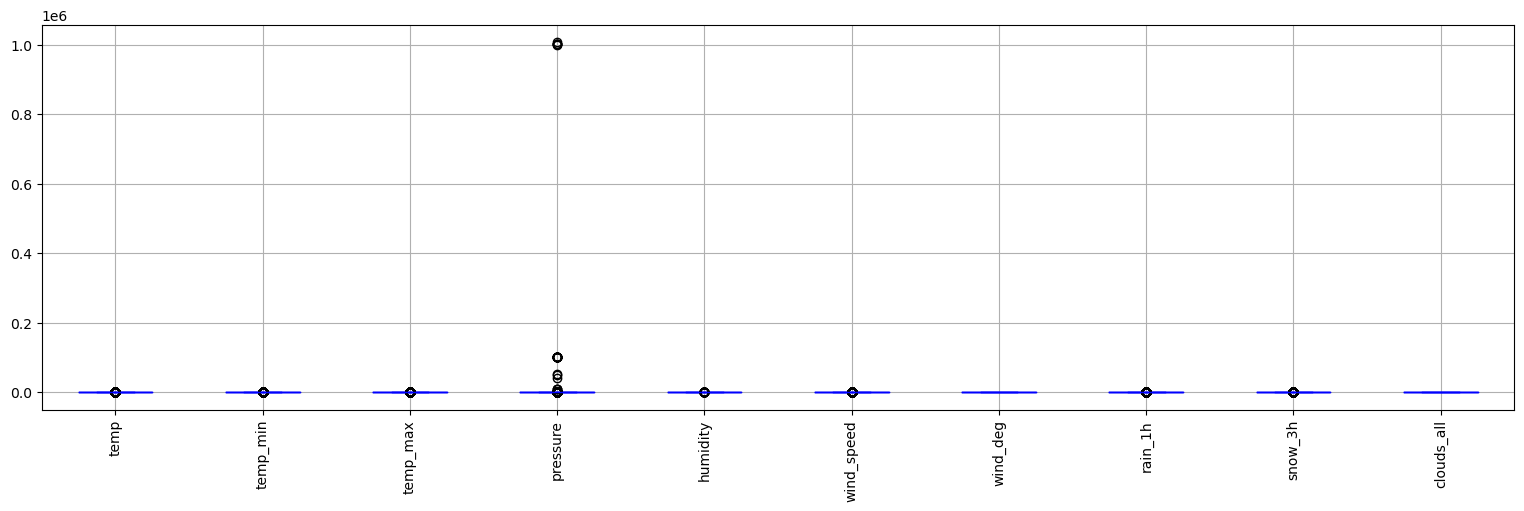

In [30]:
df_weather.boxplot(rot=90, color="blue",figsize=(19, 5))


In [31]:
#Droppping if any duplicates exists in pressure column
df_weather['pressure'].describe()# drop any duplicates
df_weather = df_weather.drop_duplicates(keep='first')

From the boxplot we can interpret that pressure variable has some outliers, pressure is measured as hPa and ranges from 955 to 1051. First lets see the total data less than or equal to 955hpa and more than or equal to 1050hpa.

In [32]:
sum(df_weather['pressure']<=955) + sum(df_weather['pressure']>=1051)

1228

Analysing the records where the pressure data is more than 1050 and less than 954

In [33]:
df_weather[df_weather['pressure']>1050]

city_name    temp  temp_min  temp_max  pressure  \
dt_iso                                                                  
2016-07-21 19:00:00    Valencia  298.94    298.71    299.26    1073.0   
2016-08-03 15:00:00    Valencia  308.34    302.75    312.04    1075.0   
2016-08-03 16:00:00    Valencia  305.31    302.75    306.48    1074.0   
2016-08-03 17:00:00    Valencia  304.55    302.55    305.37    1073.0   
2016-08-03 18:00:00    Valencia  302.94    301.65    303.71    1074.0   
...                         ...     ...       ...       ...       ...   
2015-02-22 09:00:00   Barcelona  283.86    283.86    283.86   10029.0   
2015-02-22 10:00:00   Barcelona  285.05    285.05    285.05  100304.0   
2015-02-22 11:00:00   Barcelona  285.45    285.45    285.45  100242.0   
2015-02-22 13:00:00   Barcelona  286.55    286.55    286.55  100164.0   
2015-10-17 01:00:00     Seville  293.51    289.15    300.15    1090.0   

                     humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
dt_iso                                                                  
2016-07-21 19:00:00      41.0         3.0     107.0      0.0      0.0   
2016-08-03 15:00:00      46.0         1.0     292.0      0.0      0.0   
2016-08-03 16:00:00      45.0         1.0     315.0      0.0      0.0   
2016-08-03 17:00:00      47.0         0.0     180.0      0.0      0.0   
2016-08-03 18:00:00      47.0         1.0     135.0      0.0      0.0   
...                       ...         ...       ...      ...      ...   
2015-02-22 09:00:00       0.0         1.0      67.0      0.0      0.0   
2015-02-22 10:00:00       0.0         6.0      67.0      0.0      0.0   
2015-02-22 11:00:00       0.0         7.0     337.0      0.0      0.0   
2015-02-22 13:00:00       0.0         1.0       0.0     12.0      0.0   
2015-10-17 01:00:00      87.0         2.0      30.0      0.0      0.0   

                     clouds_all weather_main  
dt_iso                                        
2016-07-21 19:00:00         0.0        clear  
2016-08-03 15:00:00        32.0       clouds  
2016-08-03 16:00:00         8.0        clear  
2016-08-03 17:00:00        20.0       clouds  
2016-08-03 18:00:00        20.0       clouds  
...                         ...          ...  
2015-02-22 09:00:00         0.0        clear  
2015-02-22 10:00:00         0.0        clear  
2015-02-22 11:00:00         0.0        clear  
2015-02-22 13:00:00         0.0         rain  
2015-10-17 01:00:00         0.0        clear  

[412 rows x 12 columns]

In [34]:
df_weather[df_weather['pressure']<955]

city_name     temp  temp_min  temp_max  pressure  \
dt_iso                                                                   
2015-01-15 13:00:00      Madrid  283.182   283.182   283.182     954.0   
2015-01-15 15:00:00      Madrid  282.863   282.863   282.863     954.0   
2015-01-16 00:00:00      Madrid  281.019   281.019   281.019     948.0   
2015-01-16 01:00:00      Madrid  280.896   280.896   280.896     948.0   
2015-01-16 04:00:00      Madrid  275.939   275.939   275.939     950.0   
...                         ...      ...       ...       ...       ...   
2015-06-08 09:00:00   Barcelona  302.250   299.820   305.930     932.0   
2015-06-10 02:00:00   Barcelona  293.340   287.590   298.150     928.0   
2015-06-25 09:00:00   Barcelona  298.700   296.480   303.150     923.0   
2015-06-28 01:00:00   Barcelona  294.810   292.040   297.040     918.0   
2015-07-18 02:00:00   Barcelona  296.670   293.710   299.260     594.0   

                     humidity  wind_speed  wind_deg  rain_1h  snow_3h  \
dt_iso                                                                  
2015-01-15 13:00:00      80.0         4.0     229.0      0.0      0.0   
2015-01-15 15:00:00      82.0         5.0     225.0      0.0      0.0   
2015-01-16 00:00:00      96.0         7.0     211.0      0.9      0.0   
2015-01-16 01:00:00      99.0         5.0     277.0      0.3      0.0   
2015-01-16 04:00:00      91.0         2.0     271.0      0.0      0.0   
...                       ...         ...       ...      ...      ...   
2015-06-08 09:00:00       7.0         0.0     113.0      0.0      0.0   
2015-06-10 02:00:00      11.0         1.0       7.0      0.0      0.0   
2015-06-25 09:00:00      10.0         4.0      66.0      0.0      0.0   
2015-06-28 01:00:00      29.0         1.0     218.0      0.0      0.0   
2015-07-18 02:00:00      30.0         1.0     223.0      0.0      0.0   

                     clouds_all weather_main  
dt_iso                                        
2015-01-15 13:00:00        12.0       clouds  
2015-01-15 15:00:00        80.0       clouds  
2015-01-16 00:00:00        92.0         rain  
2015-01-16 01:00:00        92.0         rain  
2015-01-16 04:00:00        12.0       clouds  
...                         ...          ...  
2015-06-08 09:00:00         0.0        clear  
2015-06-10 02:00:00        24.0       clouds  
2015-06-25 09:00:00         0.0        clear  
2015-06-28 01:00:00         0.0        clear  
2015-07-18 02:00:00         0.0        clear  

[749 rows x 12 columns]

In [35]:
df_weather.shape

(168456, 12)

Since weather dataset has toal 168457 rows, I am sorting the outliers in pressure column by removing the rows which will remove only 0.01% of the total rows.

In [36]:
df_weather = df_weather[df_weather['pressure']>=945] 
df_weather = df_weather[df_weather['pressure']<=1051]
# After dropping rows with wrong pressure data
df_weather.shape

(167706, 12)

<AxesSubplot: >

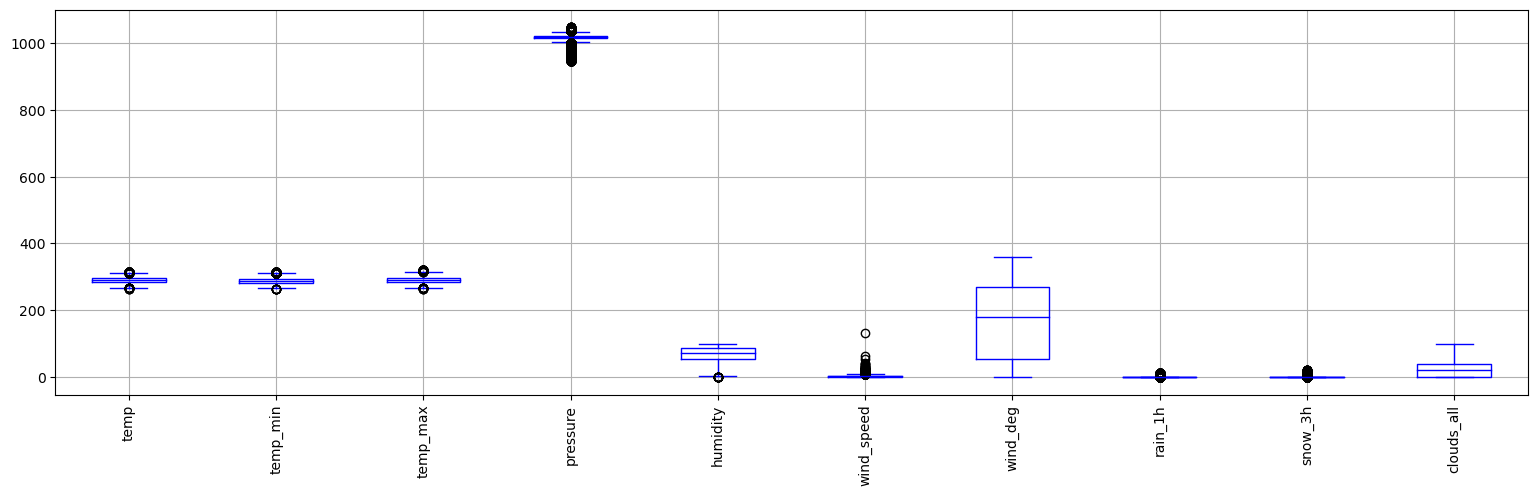

In [37]:
df_weather.boxplot(rot=90, color="blue",figsize=(19, 5))

Next we can see that their are outliers in wind speed

<AxesSubplot: >

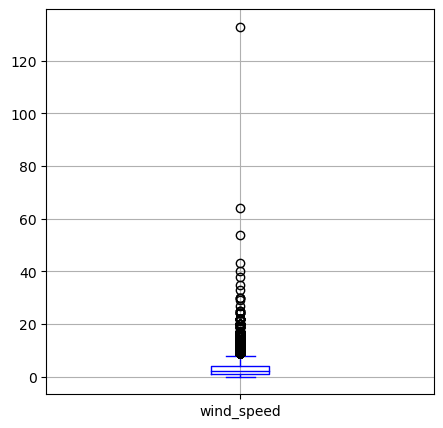

In [38]:
df_weather.boxplot(column='wind_speed', color="blue",figsize=(5, 5))

There exists outliers in windspeed and I am here considering windspeed greater than 60Km/hr to be removed for better results

<AxesSubplot: >

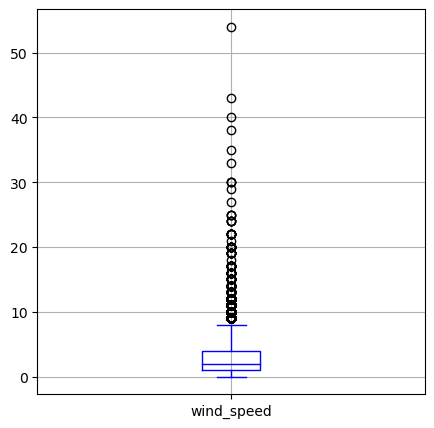

In [39]:
df_weather = df_weather[df_weather.wind_speed<=60]
df_weather.boxplot(column='wind_speed', color="blue",figsize=(5, 5))

The temperatures of weather dataset is in Kelvin here we are converting to celsius for Standardization and Practicality.
This is done by substracting 273.15 and round off to 1 decimal place by this we create new temperature columns tempC, tempC_min, tempC_max and deleting old columns (temp, temp_min amd temp_max).

<AxesSubplot: >

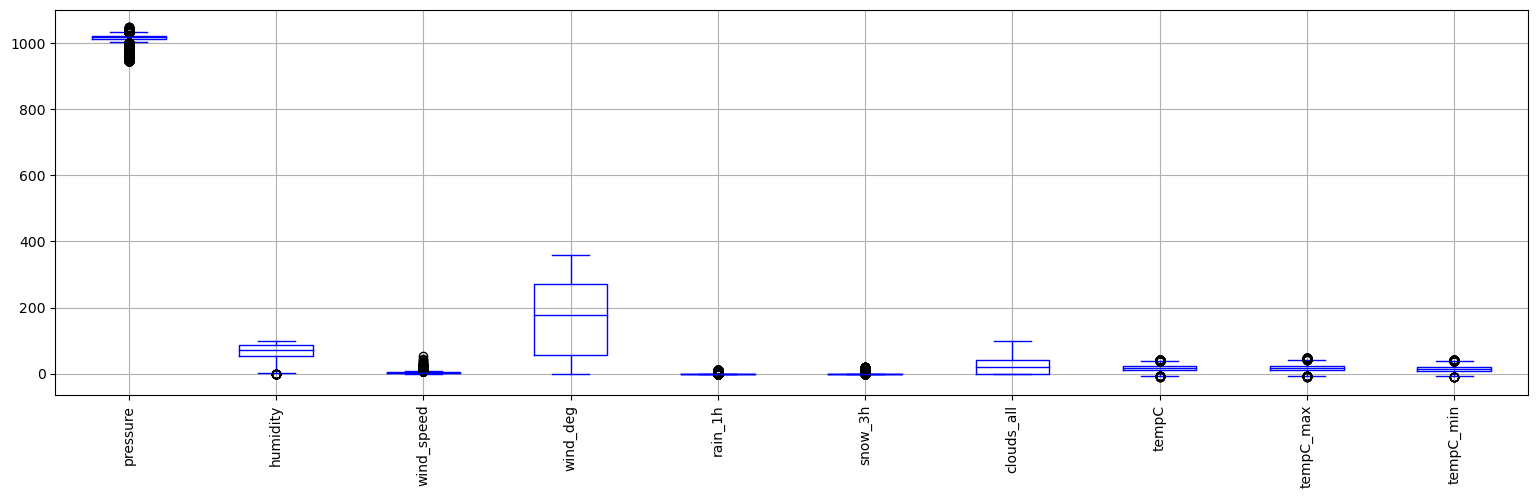

In [40]:
df_weather.loc[:, 'tempC'] = round((df_weather['temp'] - 273.15), 1)
df_weather.loc[:, 'tempC_max'] = round((df_weather['temp_max'] - 273.15), 1)
df_weather.loc[:, 'tempC_min'] = round((df_weather['temp_min'] - 273.15), 1)
df_weather.drop(columns = ['temp','temp_max','temp_min'], axis=1, inplace=True)
df_weather.boxplot(rot=90, color="blue",figsize=(19,5))

Next step is to plot a line graph of daily mean temperatures against each cities

In [41]:
df_weather['city_name'].unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

Text(0.5, 0, 'Year')

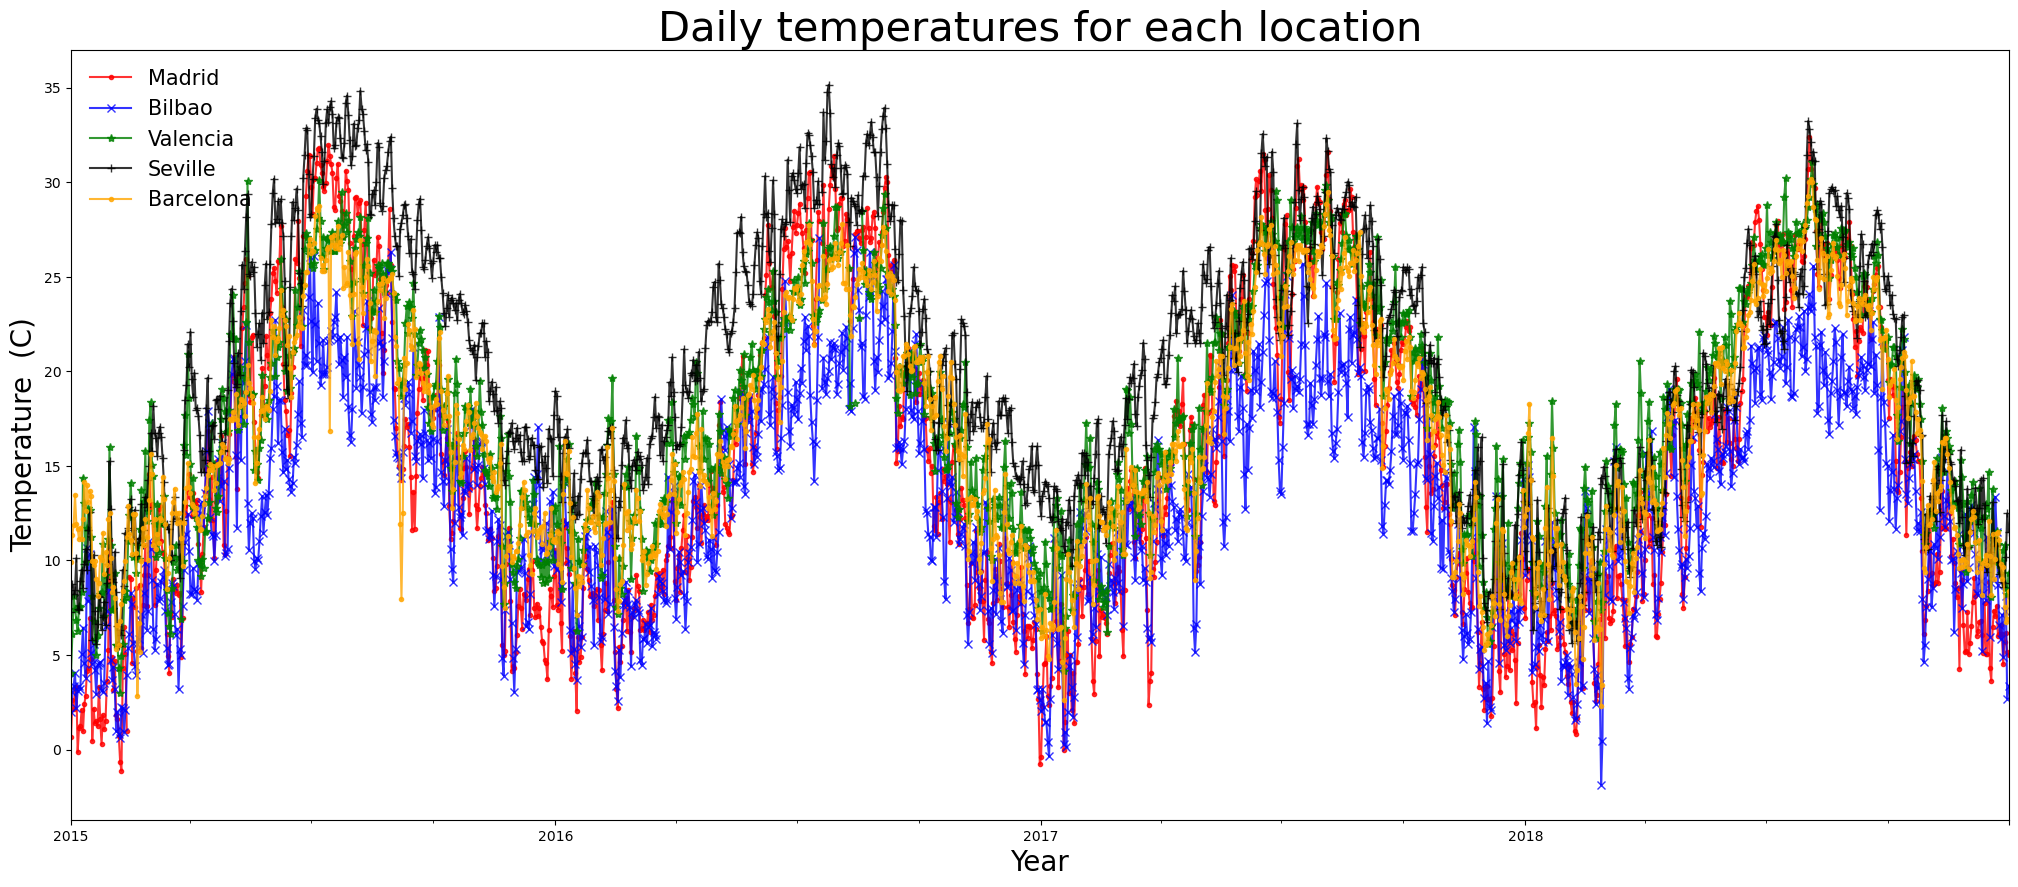

In [42]:
axes = df_weather[df_weather.city_name=='Madrid'    ]["tempC"].resample("D").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='Madrid', color='red' )
axes = df_weather[df_weather.city_name=='Bilbao'    ]["tempC"].resample("D").mean().plot(marker='x', alpha=0.8,  figsize=(25,10), label='Bilbao', color='blue')
axes = df_weather[df_weather.city_name=='Valencia'  ]["tempC"].resample("D").mean().plot(marker='*', alpha=0.8,  figsize=(25,10), label='Valencia', color='green')
axes = df_weather[df_weather.city_name=='Seville'   ]["tempC"].resample("D").mean().plot(marker='+', alpha=0.8,  figsize=(25,10), label='Seville', color='black')
axes = df_weather[df_weather.city_name==' Barcelona']["tempC"].resample("D").mean().plot(marker='.', alpha=0.8,  figsize=(25,10), label='Barcelona', color='orange')
axes.legend(loc='upper left', frameon=False, fontsize=15)
axes.set_title('Daily temperatures for each location', fontsize=30)
axes.set_ylabel('Temperature  (C)', fontsize=20)
axes.set_xlabel("Year", fontsize=20)

The temperature patterns observed in five cities Seville, Bilbao, Valencoa, Madrid, and Barcelona suggest that Seville (black) generally experiences higher temperatures, while Bilbao (blue) and Madrid (red) tend to have comparatively lower temperatures. Nevertheless it should be noted that all three cities exhibit a consistent seasonal pattern in their temperature variations.

# Merging the two datasets

In [43]:
# Weather dataset is for five cities, here I am combining the data for five cities by taking the mean for every hour
df_weather_mean = df_weather.resample("H").mean()
df_weather_mean.index.rename('Datetime', inplace=True)
df_weather_mean.head()

C:\Users\Shilpa\AppData\Local\Temp\ipykernel_16816\3816509673.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_weather_mean = df_weather.resample("H").mean()


pressure  humidity  wind_speed  wind_deg  rain_1h  \
Datetime                                                                 
2015-01-01 00:00:00    1016.2      82.4         2.0     135.8      0.0   
2015-01-01 01:00:00    1016.8      82.0         2.4     119.0      0.0   
2015-01-01 02:00:00    1035.0      97.0         1.0     225.0      0.0   
2015-01-01 03:00:00    1035.0      97.0         1.0     221.0      0.0   
2015-01-01 04:00:00    1017.4      82.6         2.4     174.8      0.0   

                     snow_3h  clouds_all  tempC  tempC_max  tempC_min  
Datetime                                                               
2015-01-01 00:00:00      0.0         0.0  -0.64      -0.64      -0.64  
2015-01-01 01:00:00      0.0         0.0  -1.08      -1.08      -1.08  
2015-01-01 02:00:00      0.0         0.0  -3.90      -3.90      -3.90  
2015-01-01 03:00:00      0.0         0.0  -3.70      -3.70      -3.70  
2015-01-01 04:00:00      0.0         0.0  -1.14      -1.14      -1.14

In [44]:
df_energy.index.rename('Datetime', inplace=True)
df_energy.index.name
df_energy.index = pd.to_datetime(df_energy.index, utc='True')
df_energy.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-01 01:00:00+00:00',
               '2015-01-01 02:00:00+00:00', '2015-01-01 03:00:00+00:00',
               '2015-01-01 04:00:00+00:00', '2015-01-01 05:00:00+00:00',
               '2015-01-01 06:00:00+00:00', '2015-01-01 07:00:00+00:00',
               '2015-01-01 08:00:00+00:00', '2015-01-01 09:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=35017, freq=None)

In [45]:
df_weather_mean.index.rename('Datetime', inplace=True)
df_weather_mean.index.name
df_weather_mean.index = pd.to_datetime(df_weather_mean.index, utc='True')
df_weather_mean.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-01 01:00:00+00:00',
               '2015-01-01 02:00:00+00:00', '2015-01-01 03:00:00+00:00',
               '2015-01-01 04:00:00+00:00', '2015-01-01 05:00:00+00:00',
               '2015-01-01 06:00:00+00:00', '2015-01-01 07:00:00+00:00',
               '2015-01-01 08:00:00+00:00', '2015-01-01 09:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=35063, freq='H')

In [46]:
#Merging the energy and weather dataset based on Datetime index
df_forecast = df_weather_mean.merge(df_energy, on='Datetime', how = 'inner')
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35017 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   pressure                                     34423 non-null  float64
 1   humidity                                     34423 non-null  float64
 2   wind_speed                                   34423 non-null  float64
 3   wind_deg                                     34423 non-null  float64
 4   rain_1h                                      34423 non-null  float64
 5   snow_3h                                      34423 non-null  float64
 6   clouds_all                                   34423 non-null  float64
 7   tempC                                        34423 non-null  float64
 8   tempC_max                                    34423 non-null  float64
 9   tempC_min                

In [47]:
df_forecast.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-01 01:00:00+00:00',
               '2015-01-01 02:00:00+00:00', '2015-01-01 03:00:00+00:00',
               '2015-01-01 04:00:00+00:00', '2015-01-01 05:00:00+00:00',
               '2015-01-01 06:00:00+00:00', '2015-01-01 07:00:00+00:00',
               '2015-01-01 08:00:00+00:00', '2015-01-01 09:00:00+00:00',
               ...
               '2018-12-31 13:00:00+00:00', '2018-12-31 14:00:00+00:00',
               '2018-12-31 15:00:00+00:00', '2018-12-31 16:00:00+00:00',
               '2018-12-31 17:00:00+00:00', '2018-12-31 18:00:00+00:00',
               '2018-12-31 19:00:00+00:00', '2018-12-31 20:00:00+00:00',
               '2018-12-31 21:00:00+00:00', '2018-12-31 22:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Datetime', length=35017, freq=None)

In [48]:
df_forecast.isna().sum()

pressure                                       594
humidity                                       594
wind_speed                                     594
wind_deg                                       594
rain_1h                                        594
snow_3h                                        594
clouds_all                                     594
tempC                                          594
tempC_max                                      594
tempC_min                                      594
generation biomass                               0
generation fossil brown coal/lignite             0
generation fossil gas                            0
generation fossil hard coal                      0
generation fossil oil                            0
generation hydro pumped storage consumption      0
generation hydro run-of-river and poundage       0
generation hydro water reservoir                 0
generation nuclear                               0
generation other               

In [49]:
columns_with_missing = df_forecast.columns[df_forecast.isnull().any()].tolist()

# Iterate over each column with missing values and perform interpolation
for column in columns_with_missing:
    df_forecast[column].interpolate(inplace=True)

# Validate the dataset after interpolation
print(df_forecast.head())

# Save the interpolated dataset
df_forecast.to_csv('interpolated_dataset.csv', index=False)

                           pressure  humidity  wind_speed  wind_deg  rain_1h  \
Datetime                                                                       
2015-01-01 00:00:00+00:00    1016.2      82.4         2.0     135.8      0.0   
2015-01-01 01:00:00+00:00    1016.8      82.0         2.4     119.0      0.0   
2015-01-01 02:00:00+00:00    1035.0      97.0         1.0     225.0      0.0   
2015-01-01 03:00:00+00:00    1035.0      97.0         1.0     221.0      0.0   
2015-01-01 04:00:00+00:00    1017.4      82.6         2.4     174.8      0.0   

                           snow_3h  clouds_all  tempC  tempC_max  tempC_min  \
Datetime                                                                      
2015-01-01 00:00:00+00:00      0.0         0.0  -0.64      -0.64      -0.64   
2015-01-01 01:00:00+00:00      0.0         0.0  -1.08      -1.08      -1.08   
2015-01-01 02:00:00+00:00      0.0         0.0  -3.90      -3.90      -3.90   
2015-01-01 03:00:00+00:00      0.0         0

In [50]:
df_forecast.isna().sum()

pressure                                       0
humidity                                       0
wind_speed                                     0
wind_deg                                       0
rain_1h                                        0
snow_3h                                        0
clouds_all                                     0
tempC                                          0
tempC_max                                      0
tempC_min                                      0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other ren

In [51]:
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35017 entries, 2015-01-01 00:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 28 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   pressure                                     35017 non-null  float64
 1   humidity                                     35017 non-null  float64
 2   wind_speed                                   35017 non-null  float64
 3   wind_deg                                     35017 non-null  float64
 4   rain_1h                                      35017 non-null  float64
 5   snow_3h                                      35017 non-null  float64
 6   clouds_all                                   35017 non-null  float64
 7   tempC                                        35017 non-null  float64
 8   tempC_max                                    35017 non-null  float64
 9   tempC_min                

In [52]:
df_forecast.describe()

pressure      humidity    wind_speed      wind_deg       rain_1h  \
count  35017.000000  35017.000000  35017.000000  35017.000000  35017.000000   
mean    1016.555524     68.360565      2.448523    167.432917      0.079941   
std        7.962568     14.983293      1.380226     59.676691      0.229482   
min      972.000000     22.600000      0.000000      0.000000      0.000000   
25%     1013.200000     57.000000      1.400000    126.000000      0.000000   
50%     1017.000000     69.800000      2.200000    167.200000      0.000000   
75%     1021.000000     80.400000      3.200000    209.200000      0.060000   
max     1039.800000    100.000000     20.000000    357.000000      5.000000   

            snow_3h    clouds_all         tempC     tempC_max     tempC_min  \
count  35017.000000  35017.000000  35017.000000  35017.000000  35017.000000   
mean       0.006233     25.311273     16.474466     17.959572     15.169865   
std        0.135199     18.125246      7.234917      7.496082      7.084278   
min        0.000000      0.000000     -3.900000     -3.900000     -3.900000   
25%        0.000000     12.000000     10.840000     12.200000      9.800000   
50%        0.000000     23.000000     15.783333     17.220000     14.500000   
75%        0.000000     35.000000     21.840000     23.600000     20.366667   
max        7.166667     94.000000     36.120000     40.380000     35.400000   

       ...  generation nuclear  generation other  generation other renewable  \
count  ...        35017.000000      35017.000000                35017.000000   
mean   ...         6263.998058         60.237599                   85.651798   
std    ...          838.274530         20.236155                   14.063855   
min    ...            0.000000          0.000000                    0.000000   
25%    ...         5760.000000         53.000000                   74.000000   
50%    ...         6564.000000         57.000000                   88.000000   
75%    ...         7024.000000         80.000000                   97.000000   
max    ...         7117.000000        106.000000                  119.000000   

       generation solar  generation waste  generation wind onshore  \
count      35017.000000      35017.000000             35017.000000   
mean        1433.093726        269.504241              5466.030699   
std         1680.330969         50.142420              3213.623111   
min            0.000000          0.000000                 0.000000   
25%           71.000000        240.000000              2935.000000   
50%          616.000000        279.000000              4850.000000   
75%         2579.000000        310.000000              7399.000000   
max         5792.000000        357.000000             17436.000000   

       total load actual  price day ahead  price actual  total generation  
count       35017.000000     35017.000000  35017.000000      35017.000000  
mean        28696.928035        49.869399     57.887053      28724.102465  
std          4574.204180        14.618346     14.190227       4173.273497  
min         18041.000000         2.060000      9.330000       6899.000000  
25%         24808.000000        41.490000     49.360000      25539.000000  
50%         28902.000000        50.520000     58.020000      28544.000000  
75%         32192.000000        60.530000     68.000000      31646.000000  
max         41015.000000       101.990000    116.800000      42330.000000  

[8 rows x 28 columns]

In [53]:
df_forecast.shape

(35017, 28)

In [54]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_forecast.'
      .format(df_forecast.isnull().values.sum()))

temp_final = df_forecast.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_forecast based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_forecast.

There are 0 duplicate rows in df_forecast based on all columns.


# XGBoost Modelling

# Target Variable Analysis

In [55]:
# Descriptive Statistics: Calculate basic statistical measures such as mean, median, standard deviation, minimum, and maximum of the "total load actual" values. 
#This provides an overview of the central tendency, spread, and range of energy demand.

target_column = 'total load actual'

mean_value = df_forecast[target_column].mean()
median_value = df_forecast[target_column].median()
std_deviation = df_forecast[target_column].std()
min_value = df_forecast[target_column].min()
max_value = df_forecast[target_column].max()

print("Descriptive Statistics for 'total load actual':")
print(f"Mean: {mean_value:.2f}")
print(f"Median: {median_value:.2f}")
print(f"Standard Deviation: {std_deviation:.2f}")
print(f"Minimum Value: {min_value:.2f}")
print(f"Maximum Value: {max_value:.2f}")

Descriptive Statistics for 'total load actual':
Mean: 28696.93
Median: 28902.00
Standard Deviation: 4574.20
Minimum Value: 18041.00
Maximum Value: 41015.00


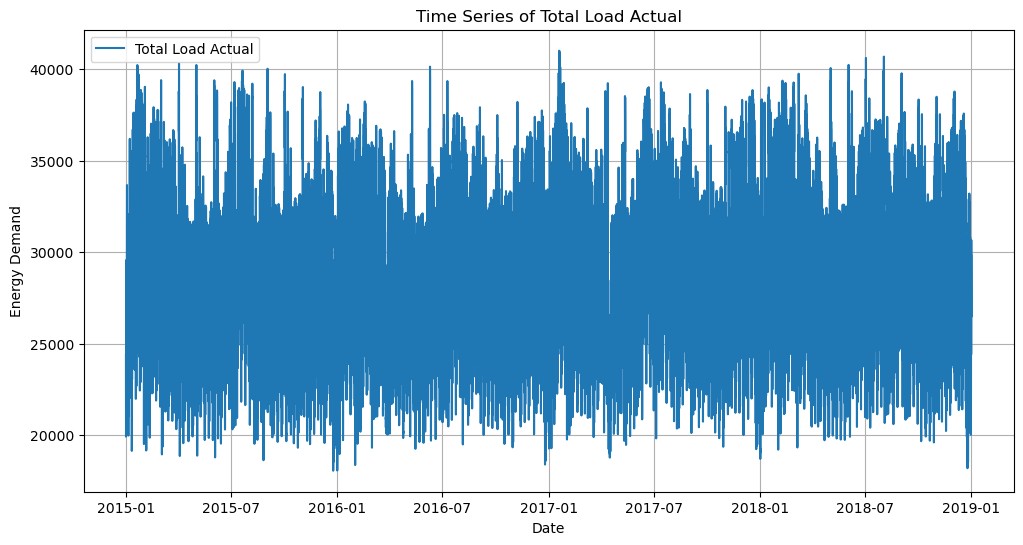

In [56]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df_forecast.index, df_forecast['total load actual'], label='Total Load Actual')
plt.title('Time Series of Total Load Actual')
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.legend()
plt.grid(True)

In [57]:
# Calculate correlation between 'total load actual' and other features
correlation_with_total_load = df_forecast[['total load actual', 'pressure', 'tempC', 'humidity']].corr()
print(correlation_with_total_load)

                   total load actual  pressure     tempC  humidity
total load actual           1.000000 -0.004438  0.206669 -0.369619
pressure                   -0.004438  1.000000 -0.128709 -0.015622
tempC                       0.206669 -0.128709  1.000000 -0.669866
humidity                   -0.369619 -0.015622 -0.669866  1.000000


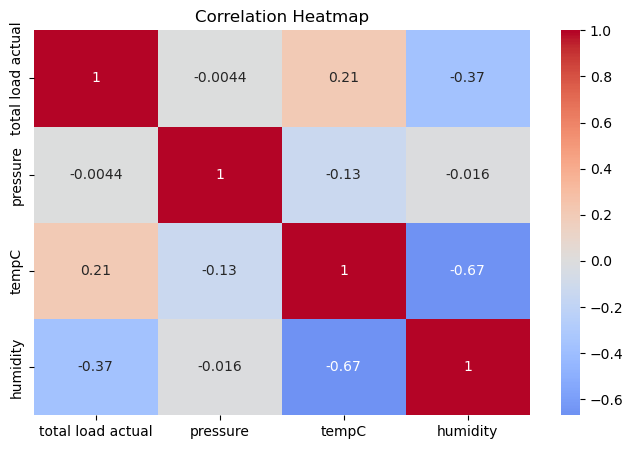

In [58]:
# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_with_total_load, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

From the correlation matrix,
• The ‘total load actual’ has a positive correlation 0.207 with temperature (tempC), 
indicating that higher the temperature higher the energy demand.
• The ‘total load actual’ has a negative correlation -0.307 with ‘humidity’, indicating higher 
humidity lower the energy demand.
• The ‘total load actual’ has a weak negative correlation of -0.004 with ‘pressure’.


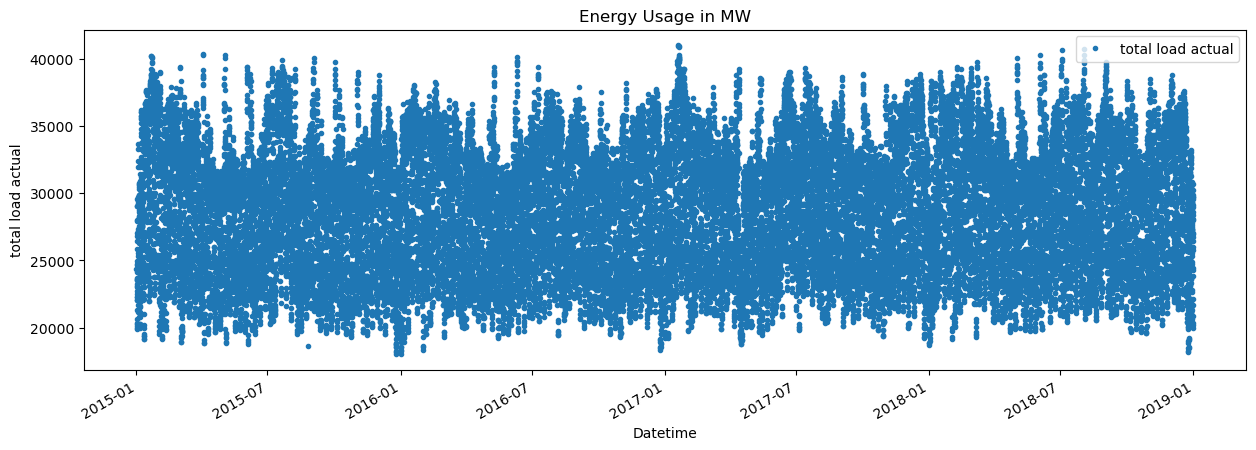

In [59]:

# Set the color palette
color_pal = sns.color_palette("tab10")

# Plot the specific column against the date index
ax = df_forecast.plot(y='total load actual', style='.', figsize=(15, 5), color=color_pal[0], title='Energy Usage in MW')
ax.set_xlabel('Datetime')
ax.set_ylabel('total load actual')
plt.show()

Train/Test Split Data
To calculate the percentage or ratio of train and test data, you can use the following steps:

Add the lengths of both the train and test data to get the total length of the dataset: Total length = Length of train data + Length of test data Total length = 26259 + 8757 = 35016

Train percentage = (Length of train data / Total length) * 100 Train percentage = (26259 / 35016) * 100 ≈ 74.85%

Test percentage = (Length of test data / Total length) * 100 Test percentage = (8757 / 35016) * 100 ≈ 25.15%

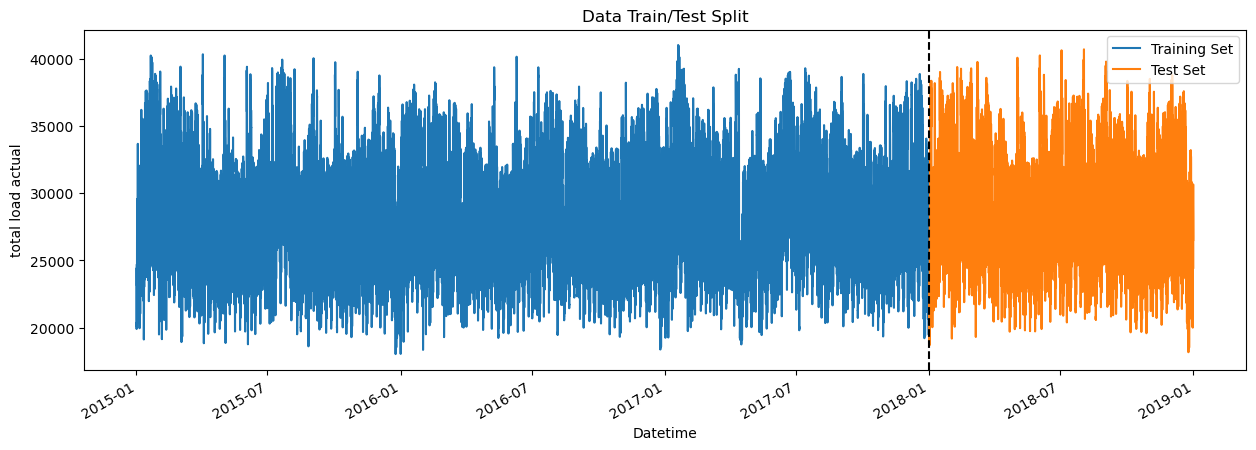

In [60]:
df_forecast.index = pd.to_datetime(df_forecast.index)

# Perform train-test split based on time
train = df_forecast.loc[df_forecast.index < '01-01-2018', 'total load actual']
test = df_forecast.loc[df_forecast.index >= '01-01-2018', 'total load actual']

# Create the plot
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2018', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.ylabel('total load actual')
plt.show()

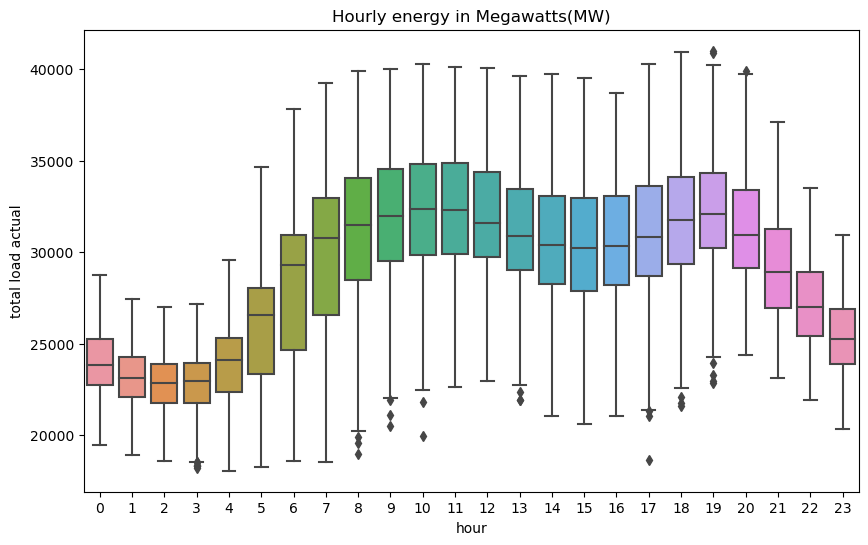

In [62]:
# Hourly energy in Megawatts(MW)
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_forecast, x='hour', y='total load actual')
ax.set_title('Hourly energy in Megawatts(MW)')
plt.show()


# From this it can be analysed that early in the morning their is a dip in energy use and tends to get higher during mid morning and noon,
# Also lower during mid afternoon and higher in the evening , night and reduces at midnight

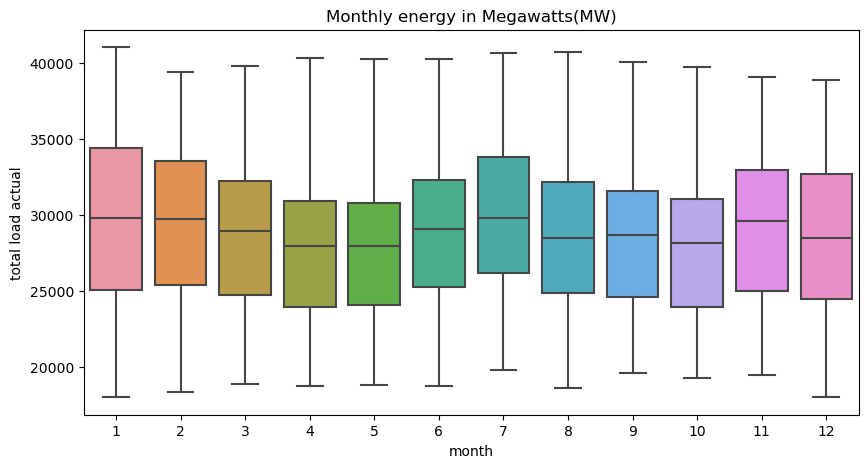

In [63]:
# Monthly energy in Megawatts(MW)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_forecast, x='month', y='total load actual')
ax.set_title('Monthly energy in Megawatts(MW)')
plt.show()


# Here it is observed that energy usage tends to peak two times in the winter season.
# During fall and spring season lower and another peak in the middle of summer(July)

# XGBoost Model with Temporal Features

In [64]:
import pandas as pd

# Assuming df_forecast is your DataFrame
# Convert the index to a DatetimeIndex
df_forecast.index = pd.to_datetime(df_forecast.index)

# Function to create time series features based on time index
def create_features(df):
    """
    Create time series features based on time series index.
    """
    # Check if the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("The index of the DataFrame must be a DatetimeIndex.")

    # Create the features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

# Apply the function to df_forecast
df_forecast = create_features(df_forecast)

# Split the data into train and test sets
train_size = int(len(df_forecast) * 0.8)
train = df_forecast.iloc[:train_size]
test = df_forecast.iloc[train_size:]

# Print the train and test datasets
print(train)
print(test)


                              pressure  humidity  wind_speed    wind_deg  \
Datetime                                                                   
2015-01-01 00:00:00+00:00  1016.200000      82.4    2.000000  135.800000   
2015-01-01 01:00:00+00:00  1016.800000      82.0    2.400000  119.000000   
2015-01-01 02:00:00+00:00  1035.000000      97.0    1.000000  225.000000   
2015-01-01 03:00:00+00:00  1035.000000      97.0    1.000000  221.000000   
2015-01-01 04:00:00+00:00  1017.400000      82.6    2.400000  174.800000   
...                                ...       ...         ...         ...   
2018-03-14 20:00:00+00:00  1001.800000      78.4    5.200000  238.000000   
2018-03-14 21:00:00+00:00  1001.600000      78.6    3.000000  182.000000   
2018-03-14 22:00:00+00:00  1001.666667      81.0    5.166667  150.666667   
2018-03-14 23:00:00+00:00  1000.600000      77.6    6.600000  223.800000   
2018-03-15 00:00:00+00:00  1000.200000      77.2    3.800000  176.000000   

           

In [65]:

# Create the train and test datasets
train = df_forecast.loc[df_forecast.index < '01-01-2018']
test = df_forecast.loc[df_forecast.index >= '01-01-2018']

# Create features using the updated index
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter','month', 'year', 'dayofyear', 'dayofmonth']
TARGET = 'total load actual'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

C:\Users\Shilpa\AppData\Local\Temp\ipykernel_16816\1413747734.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df.index.hour
C:\Users\Shilpa\AppData\Local\Temp\ipykernel_16816\1413747734.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek'] = df.index.dayofweek
C:\Users\Shilpa\AppData\Local\Temp\ipykernel_16816\1413747734.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [66]:
# Define Model
reg_model = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
# fit the model
reg_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:28647.18250	validation_1-rmse:29143.25809
[100]	validation_0-rmse:10745.40237	validation_1-rmse:11229.85300
[200]	validation_0-rmse:4460.79661	validation_1-rmse:4902.21892
[300]	validation_0-rmse:2519.53810	validation_1-rmse:2905.22806
[400]	validation_0-rmse:1959.77739	validation_1-rmse:2393.04034
[500]	validation_0-rmse:1749.58214	validation_1-rmse:2277.52673
[600]	validation_0-rmse:1644.28519	validation_1-rmse:2242.85567
[700]	validation_0-rmse:1546.05499	validation_1-rmse:2232.83890
[753]	validation_0-rmse:1505.38629	validation_1-rmse:2234.14938


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [67]:
test['prediction'] = reg_model.predict(X_test)
df_forecast = df_forecast.merge(test[['prediction']],how='left', left_index=True, right_index=True)

C:\Users\Shilpa\AppData\Local\Temp\ipykernel_16816\4110408945.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg_model.predict(X_test)


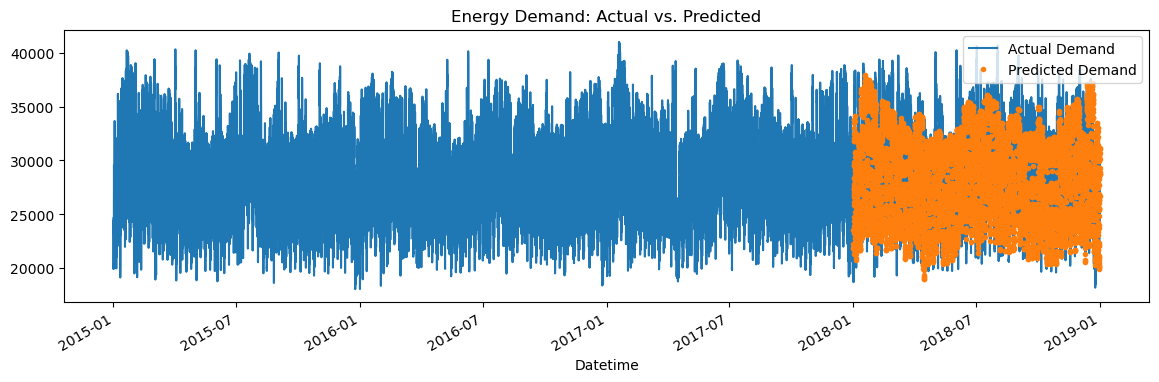

In [68]:
# Plotting the actual energy demand and predicted values
ax = df_forecast[['total load actual']].plot(figsize=(14, 4)) 
df_forecast['prediction'].plot(ax=ax, style='.') 
plt.legend(['Actual Demand', 'Predicted Demand'])
ax.set_title('Energy Demand: Actual vs. Predicted')  
plt.show()

In [69]:
# Score (RMSE)
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(test['total load actual'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2232.46


In [70]:
def calculate_mape(y_true, y_pred):
    n = len(y_true)
    mape = (1/n) * np.sum(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

# Calculate MAPE
mape = calculate_mape(test['total load actual'], test['prediction'])
print(f'MAPE on Test set: {mape:0.2f}%')

MAPE on Test set: 5.55%


# XGBoost Modelling with Temporal and lag features

In [66]:
def create_features(df_forecast):
    # Check if the index is a DatetimeIndex
    if not isinstance(df_forecast.index, pd.DatetimeIndex):
        raise TypeError("The index of the DataFrame must be a DatetimeIndex.")

    # Create the features
    df_forecast['hour'] = df_forecast.index.hour
    df_forecast['dayofweek'] = df_forecast.index.dayofweek
    df_forecast['quarter'] = df_forecast.index.quarter
    df_forecast['month'] = df_forecast.index.month
    df_forecast['year'] = df_forecast.index.year
    df_forecast['dayofyear'] = df_forecast.index.dayofyear
    df_forecast['dayofmonth'] = df_forecast.index.day
    return df_forecast

df_forecast = create_features(df_forecast)
df_forecast.columns

Index(['pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'tempC', 'tempC_max', 'tempC_min', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'total generation', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth'],
      dtype='object')

In [71]:
def add_lags(df_forecast):
    target_map = df_forecast['total load actual'].to_dict()
    df_forecast['lag1'] = (df_forecast.index - pd.Timedelta('364 days')).map(target_map)
    df_forecast['lag2'] = (df_forecast.index - pd.Timedelta('728 days')).map(target_map)
    df_forecast['lag3'] = (df_forecast.index - pd.Timedelta('1092 days')).map(target_map)
    return df_forecast
df_forecast = add_lags(df_forecast)

In [72]:
# List of columns with null values
columns_with_nulls = ['lag1', 'lag2', 'lag3']

# Drop rows with null values in the specified columns
df_forecast.dropna(subset=columns_with_nulls, inplace=True)



In [73]:
df_forecast.isnull().sum()

pressure                                        0
humidity                                        0
wind_speed                                      0
wind_deg                                        0
rain_1h                                         0
snow_3h                                         0
clouds_all                                      0
tempC                                           0
tempC_max                                       0
tempC_min                                       0
generation biomass                              0
generation fossil brown coal/lignite            0
generation fossil gas                           0
generation fossil hard coal                     0
generation fossil oil                           0
generation hydro pumped storage consumption     0
generation hydro run-of-river and poundage      0
generation hydro water reservoir                0
generation nuclear                              0
generation other                                0


In [74]:
df_forecast.drop('prediction', axis=1, inplace=True)


In [75]:
df_forecast.isnull().sum()

pressure                                       0
humidity                                       0
wind_speed                                     0
wind_deg                                       0
rain_1h                                        0
snow_3h                                        0
clouds_all                                     0
tempC                                          0
tempC_max                                      0
tempC_min                                      0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other ren

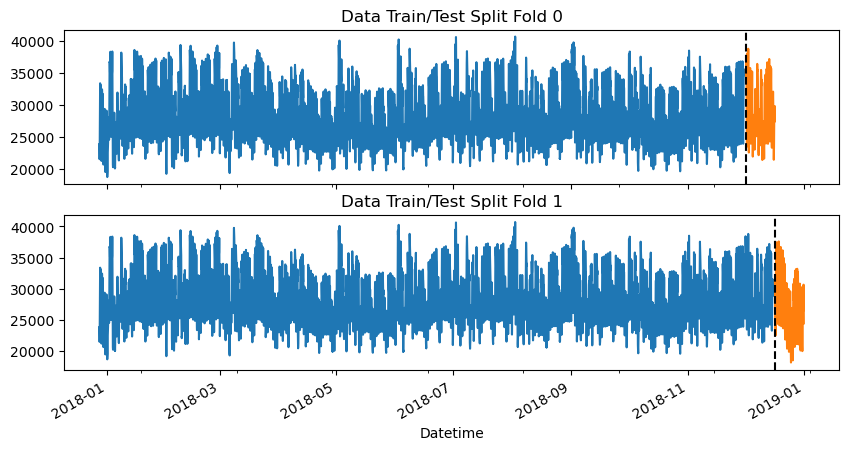

In [76]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=24)
df_forecast = df_forecast.sort_index()
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_forecast):
    train = df_forecast.iloc[train_idx]
    test = df_forecast.iloc[val_idx]
    train['total load actual'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['total load actual'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [77]:
# Model Training and Predicting
tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=24)
fold = 0
preds = []
actual_values = []
scores = []
actual_values_list = []  # List to store actual values for each fold
predicted_values_list = []  # List to store predicted values for each fold
for train_idx, val_idx in tss.split(df_forecast):
    train = df_forecast.iloc[train_idx].copy()
    test = df_forecast.iloc[val_idx].copy()
    train = create_features(train)
    test = create_features(test)
    FEATURES = ['hour', 'dayofweek', 'quarter','month', 'year', 'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3']
    TARGET = 'total load actual'
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    # Store actual values for each fold
    actual_values.append(y_test)
    actual_values_list.append(y_test)  # Add actual values to the list
    
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    
    predicted_values_list.append(y_pred)  # Add predicted values to the list

    fold += 1

print("Scores for 2 Folds:", scores)

[08:03:25] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29117.96375	validation_1-rmse:29731.00699
[100]	validation_0-rmse:10925.13609	validation_1-rmse:11527.88578
[200]	validation_0-rmse:4561.14198	validation_1-rmse:5340.82532
[300]	validation_0-rmse:2661.15542	validation_1-rmse:3545.99241
[400]	validation_0-rmse:2183.33840	validation_1-rmse:3173.60288
[500]	validation_0-rmse:2017.02243	validation_1-rmse:3045.14765
[600]	validation_0-rmse:1927.14088	validation_1-rmse:3027.77330
[700]	validation_0-rmse:1859.90404	validation_1-rmse:3007.41989
[800]	validation_0-rmse:1806.73365	validation_1-rmse:2983.76458
[854]	validation_0-rmse:1779.37619	validation_1-rmse:2987.26513
[08:03:27] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	vali

In [78]:
# MAPE for each fold
mape_scores = []

for fold, (y_test, y_pred) in enumerate(zip(actual_values, preds)):
    mape = calculate_mape(y_test, y_pred)
    mape_scores.append(mape)
    print(f"MAPE for Fold {fold}: {mape:.2f}%")

print("MAPE Scores for 2 Folds:", mape_scores)
print(f'Average MAPE Score across folds with Temporal and lag features: {np.mean(mape_scores):.2f}%')
print(f'MAPE scores across Fold 0 and Fold 1: {mape_scores}')

MAPE for Fold 0: 7.37%
MAPE for Fold 1: 6.46%
MAPE Scores for 2 Folds: [7.3730046070085615, 6.458454586249064]
Average MAPE Score across folds with Temporal and lag features: 6.92%
MAPE scores across Fold 0 and Fold 1: [7.3730046070085615, 6.458454586249064]


In [79]:
# Calculate RMSE for each fold
rmse_scores = []

for fold, (y_test, y_pred) in enumerate(zip(actual_values, preds)):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"RMSE for Fold {fold}: {rmse:.2f}")

print("RMSE Scores for 2 Folds:", rmse_scores)
print(f'Average RMSE Score across folds with Temporal and lag features: {np.mean(rmse_scores):.4f}')
print(f'RMSE scores across Fold 0 and Fold 1: {rmse_scores}')

RMSE for Fold 0: 2982.02
RMSE for Fold 1: 2364.08
RMSE Scores for 2 Folds: [2982.01888588756, 2364.081389032114]
Average RMSE Score across folds with Temporal and lag features: 2673.0501
RMSE scores across Fold 0 and Fold 1: [2982.01888588756, 2364.081389032114]


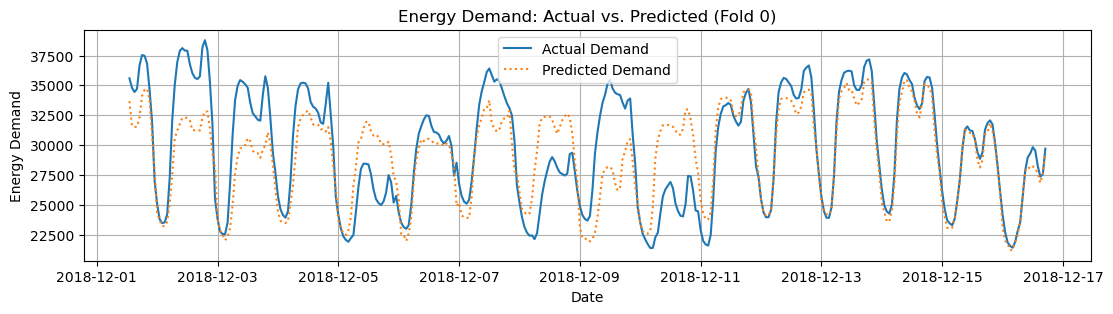

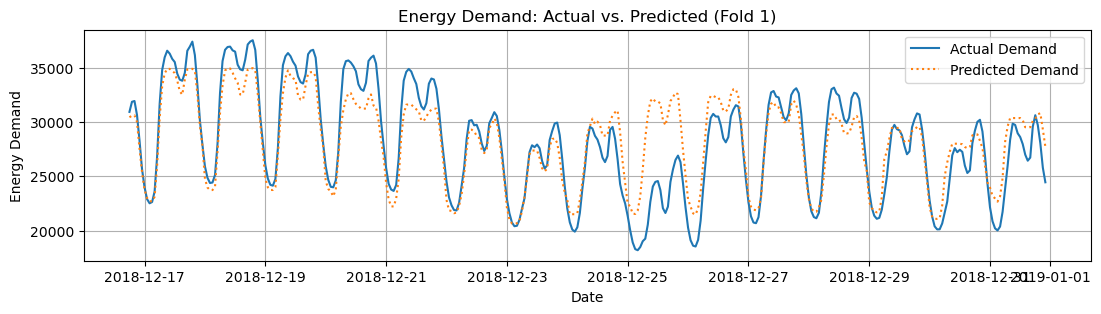

In [80]:
# Plotting the actual energy demand and predicted values for each fold
for fold, actual_values_fold, predicted_values_fold in zip(range(len(actual_values_list)), actual_values_list, predicted_values_list):
    plt.figure(figsize=(13, 3))
    plt.plot(actual_values_fold.index, actual_values_fold, label='Actual Demand')
    plt.plot(actual_values_fold.index, predicted_values_fold, label='Predicted Demand', linestyle='dotted')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.title(f'Energy Demand: Actual vs. Predicted (Fold {fold})')
    plt.legend()
    plt.grid(True)
    plt.show()

# XGBoost Modelling for Temporal, lag and additional features

In [81]:
# Model Training and Predicting
tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=24)
fold = 0
preds = []
actual_values = []
scores = []
actual_values_list = []  # List to store actual values for each fold
predicted_values_list = []  # List to store predicted values for each fold
for train_idx, val_idx in tss.split(df_forecast):
    train = df_forecast.iloc[train_idx].copy()
    test = df_forecast.iloc[val_idx].copy()
    train = create_features(train)
    test = create_features(test)
    FEATURES = ['hour', 'dayofweek', 'quarter','month', 'year', 'dayofyear', 
                'dayofmonth', 'lag1', 'lag2', 'lag3', 'tempC', 'humidity']
    TARGET = 'total load actual'
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    # Store actual values for each fold
    actual_values.append(y_test)
    actual_values_list.append(y_test)  # Add actual values to the list
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    predicted_values_list.append(y_pred)  # Add predicted values to the list
    fold += 1
print("Scores for 2 Folds:", scores)

[08:04:28] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29117.96375	validation_1-rmse:29731.00699
[100]	validation_0-rmse:10925.13609	validation_1-rmse:11527.88578
[200]	validation_0-rmse:4560.13975	validation_1-rmse:5339.77132
[300]	validation_0-rmse:2657.39749	validation_1-rmse:3569.66590
[400]	validation_0-rmse:2174.40357	validation_1-rmse:3206.13022
[500]	validation_0-rmse:2006.54666	validation_1-rmse:3078.35409
[600]	validation_0-rmse:1929.30767	validation_1-rmse:3067.71867
[700]	validation_0-rmse:1879.83368	validation_1-rmse:3048.38148
[800]	validation_0-rmse:1841.14181	validation_1-rmse:3037.62515
[900]	validation_0-rmse:1805.26023	validation_1-rmse:3028.25875
[999]	validation_0-rmse:1778.81752	validation_1-rmse:3021.85490
[08:04:31] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg

In [82]:
# MAPE for each fold
mape_scores = []

for fold, (y_test, y_pred) in enumerate(zip(actual_values, preds)):
    mape = calculate_mape(y_test, y_pred) 
    mape_scores.append(mape)
    print(f"MAPE for Fold {fold}: {mape:.2f}%")

print("MAPE Scores for 2 Folds:", mape_scores)
print(f'Average MAPE Score across folds with Temporal,lag and additional features: {np.mean(mape_scores):.2f}%')
print(f'MAPE scores across Fold 0 and Fold 1: {mape_scores}')

MAPE for Fold 0: 7.48%
MAPE for Fold 1: 6.51%
MAPE Scores for 2 Folds: [7.477125883873435, 6.506831673497447]
Average MAPE Score across folds with Temporal,lag and additional features: 6.99%
MAPE scores across Fold 0 and Fold 1: [7.477125883873435, 6.506831673497447]


In [83]:

# RMSE for each fold
rmse_scores = []

for fold, (y_test, y_pred) in enumerate(zip(actual_values, preds)):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)
    print(f"RMSE for Fold {fold}: {rmse:.2f}")

print("RMSE Scores for 2 Folds:", rmse_scores)
print(f'Average RMSE Score across folds with Temporal,lag and additional features: {np.mean(rmse_scores):.4f}')
print(f'RMSE scores across Fold 0 and Fold 1: {rmse_scores}')

RMSE for Fold 0: 3018.56
RMSE for Fold 1: 2396.17
RMSE Scores for 2 Folds: [3018.5559644246405, 2396.1740662833067]
Average RMSE Score across folds with Temporal,lag and additional features: 2707.3650
RMSE scores across Fold 0 and Fold 1: [3018.5559644246405, 2396.1740662833067]


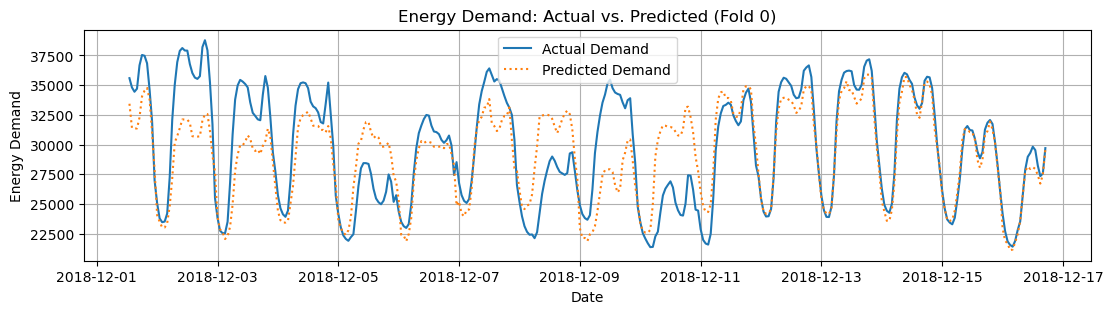

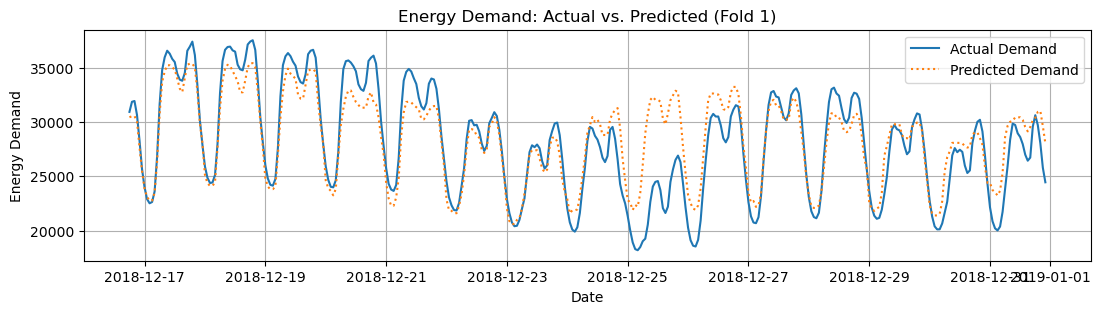

In [84]:
# Plotting the actual energy demand and predicted values for each fold
for fold, actual_values_fold, predicted_values_fold in zip(range(len(actual_values_list)), actual_values_list, predicted_values_list):
    plt.figure(figsize=(13, 3))
    plt.plot(actual_values_fold.index, actual_values_fold, label='Actual Demand')
    plt.plot(actual_values_fold.index, predicted_values_fold, label='Predicted Demand', linestyle='dotted')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.title(f'Energy Demand: Actual vs. Predicted (Fold {fold})')
    plt.legend()
    plt.grid(True)
    plt.show()

In [85]:
df_forecast.isnull().sum()

pressure                                       0
humidity                                       0
wind_speed                                     0
wind_deg                                       0
rain_1h                                        0
snow_3h                                        0
clouds_all                                     0
tempC                                          0
tempC_max                                      0
tempC_min                                      0
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other ren

# Comparison with other Models

In [80]:
df_forecast.columns

Index(['pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'snow_3h',
       'clouds_all', 'tempC', 'tempC_max', 'tempC_min', 'generation biomass',
       'generation fossil brown coal/lignite', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'total generation', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'lag1', 'lag2', 'lag3'],
      dtype='object')

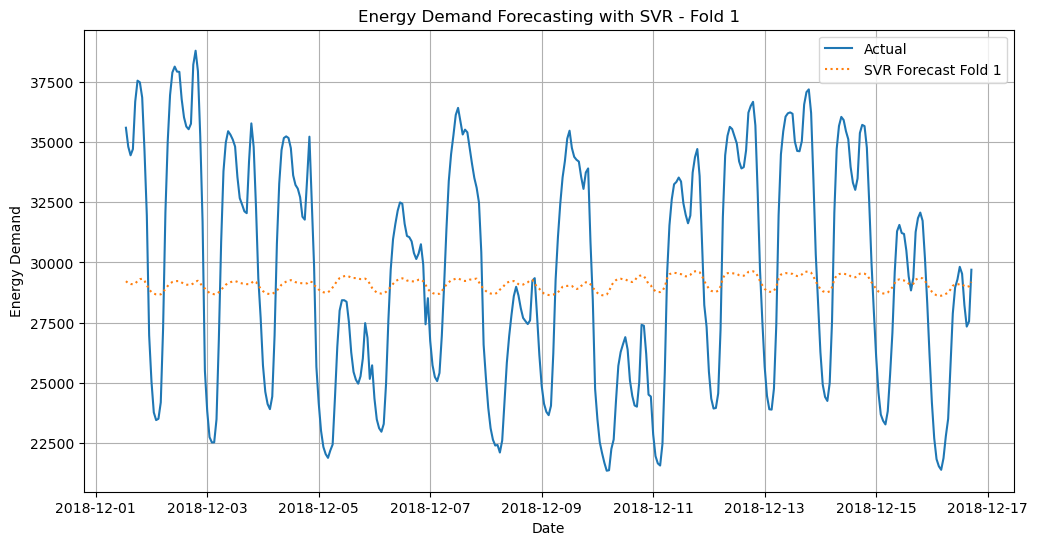

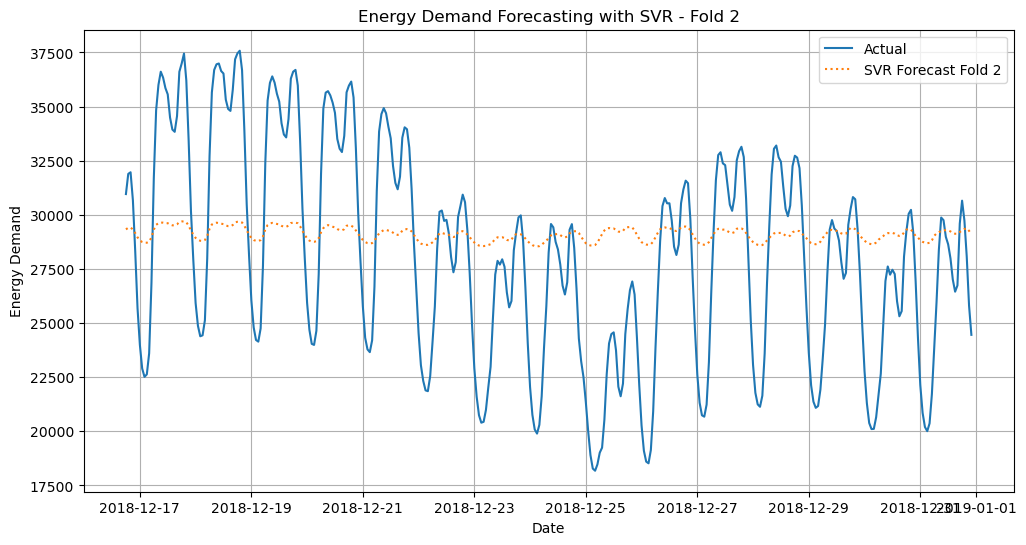

RMSE Scores across Folds: [4607.044264084242, 4795.95272770239]
Average RMSE: 4701.498495893316


In [648]:
# SVR Model
from sklearn.svm import SVR

# Initialize the TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=24)

# Initialize lists to store results
rmse_scores = []
actual_values_list = []
predicted_values_list = []

for fold, (train_idx, test_idx) in enumerate(tss.split(df_forecast)):
    train = df_forecast.iloc[train_idx]
    test = df_forecast.iloc[test_idx]
    
    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 
                'dayofmonth', 'lag1', 'lag2', 'lag3', 'tempC', 'humidity']
    TARGET = 'total load actual'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # Initialize the SVR model
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    
    # Fit the model on the training data
    svr_model.fit(X_train, y_train)
    
    # Predict using the trained model
    y_pred_svr = svr_model.predict(X_test)
    
    # Calculate RMSE for SVR
    rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
    rmse_scores.append(rmse_svr)
    
    # Store actual and predicted values for each fold
    actual_values_list.append(y_test)
    predicted_values_list.append(y_pred_svr)

# Print RMSE scores across folds
print("RMSE Scores across Folds:", rmse_scores)

# Calculate and print average RMSE
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)


In [83]:
# Random Forest
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

# Initialize the TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=24)

# Initialize lists to store results
rmse_scores = []

# Initialize the Random Forest regressor
rf_model = RandomForestRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=tss, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:")
print(best_model.get_params())

# Iterate over the TimeSeriesSplit splits
for train_idx, test_idx in tss.split(df_forecast):
    train = df_forecast.iloc[train_idx]
    test = df_forecast.iloc[test_idx]
    
    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 
                'dayofmonth', 'lag1', 'lag2', 'lag3', 'tempC', 'humidity']
    TARGET = 'total load actual'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # Predict using the best model
    y_pred_rf = best_model.predict(X_test)
    
    # Calculate RMSE for Random Forest
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    rmse_scores.append(rmse_rf)

# Print RMSE scores across folds
print("RMSE Scores across Folds:", rmse_scores)

# Calculate and print average RMSE
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)


Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV] END ......................max_depth=5, n_estimators=100; total time=   2.7s
[CV] END ......................max_depth=5, n_estimators=100; total time=   2.7s
[CV] END ......................max_depth=5, n_estimators=200; total time=   5.0s
[CV] END ......................max_depth=5, n_estimators=200; total time=   5.7s
[CV] END ......................max_depth=5, n_estimators=300; total time=   7.7s
[CV] END ......................max_depth=5, n_estimators=300; total time=   8.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   5.3s
[CV] END .....................max_depth=10, n_estimators=100; total time=   5.7s
[CV] END .....................max_depth=10, n_estimators=200; total time=  10.3s
[CV] END .....................max_depth=10, n_estimators=200; total time=  10.6s
[CV] END .....................max_depth=10, n_estimators=300; total time=  15.4s
[CV] END .....................max_depth=10, n_est

In [85]:
# Gradient Boosting Regressor
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor

# Initialize the TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=24)

# Initialize lists to store results
rmse_scores = []

# Initialize the Gradient Boosting regressor
gb_model = GradientBoostingRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(gb_model, param_grid, cv=tss, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Get the best parameters
best_params = best_model.get_params()

# Initialize lists to store RMSE scores
rmse_scores = []

# Iterate over the TimeSeriesSplit splits
for train_idx, test_idx in tss.split(df_forecast):
    train = df_forecast.iloc[train_idx]
    test = df_forecast.iloc[test_idx]
    
    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 
                'dayofmonth', 'lag1', 'lag2', 'lag3', 'tempC', 'humidity']
    TARGET = 'total load actual'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # Predict using the best model
    y_pred_gb = best_model.predict(X_test)
    
    # Calculate RMSE for Gradient Boosting
    rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
    rmse_scores.append(rmse_gb)

# Print best parameters
print("Best Parameters:")
print(best_params)

# Print RMSE scores across folds
print("RMSE Scores across Folds:", rmse_scores)

# Calculate and print average RMSE
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)


Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   4.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   4.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   9.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   9.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  13.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=  14.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   8.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   7.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=  15.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=  16.0s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=  23.1s
[CV] END ..learning_rate=0.01, max_depth=5, n_es

# XGBoostRegressor after hyperparemter tuning

In [ ]:
# Hyperparameter tuning for XGBoost Regressor

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.5s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.9s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   1.4s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   1.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   0.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=300; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_es

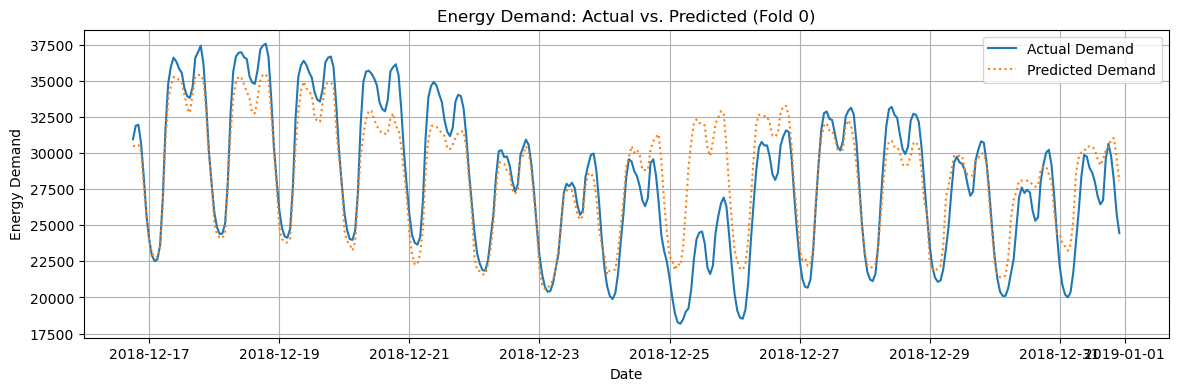

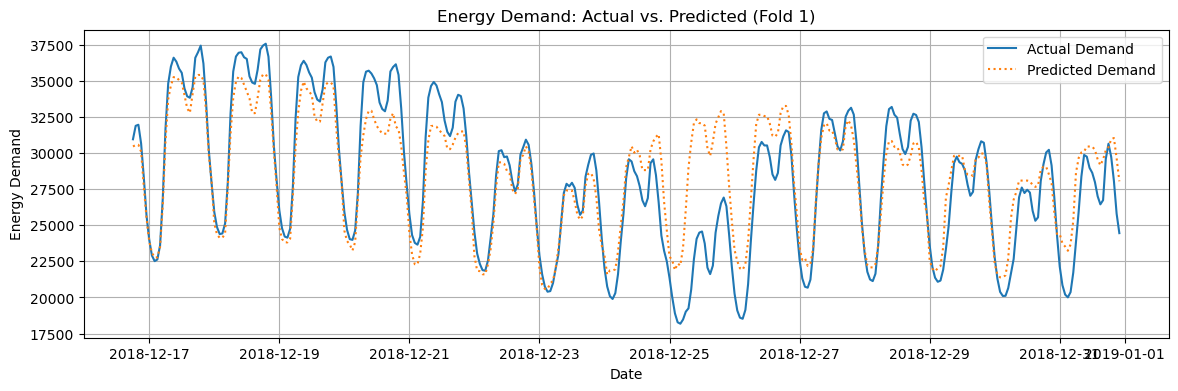

Best Parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 300, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
RMSE Scores across Folds: [1028.376795553426, 2375.9751198839317]
MAPE Scores across Folds: 

In [104]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV


# Initialize the TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=24)

# Initialize lists to store results
rmse_scores = []
mape_scores = []

# Initialize the XGBoost regressor
xgb_model = XGBRegressor()

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=tss, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model from Grid Search
best_model = grid_search.best_estimator_

# Get the best parameters
best_params = best_model.get_params()

# Initialize lists to store scores
rmse_scores = []
mape_scores = []

# Iterate over the TimeSeriesSplit splits
for fold, (train_idx, test_idx) in enumerate(tss.split(df_forecast)):
    train = df_forecast.iloc[train_idx]
    test = df_forecast.iloc[test_idx]
    
    FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 
                'dayofmonth', 'lag1', 'lag2', 'lag3', 'tempC', 'humidity']
    TARGET = 'total load actual'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    # Predict using the best model
    y_pred_xgb = best_model.predict(X_test)
    
    # Calculate RMSE for XGBoost
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    rmse_scores.append(rmse_xgb)
    
    # Calculate MAPE for XGBoost
    mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)
    mape_scores.append(mape_xgb)

    # Plot actual vs. predicted values for each fold
    plt.figure(figsize=(14, 4))
    plt.plot(actual_values_fold.index, actual_values_fold, label='Actual Demand')
    plt.plot(actual_values_fold.index, predicted_values_fold, label='Predicted Demand', linestyle='dotted')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.title(f'Energy Demand: Actual vs. Predicted (Fold {fold})')
    plt.legend()
    plt.grid(True)
    plt.show()

# Print best parameters
print("Best Parameters:")
print(best_params)

# Print RMSE scores across folds
print("RMSE Scores across Folds:", rmse_scores)

# Print MAPE scores across folds
print("MAPE Scores across Folds:", mape_scores)

# Calculate and print average RMSE
average_rmse = np.mean(rmse_scores)
print("Average RMSE:", average_rmse)

# Calculate and print average MAPE
average_mape = np.mean(mape_scores)
print("Average MAPE:", average_mape)


# Feature Importance

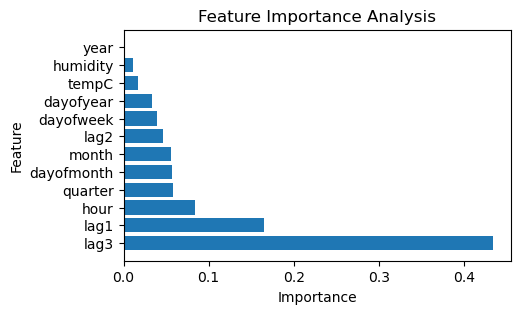

In [101]:
# Feature Importance
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

# Load and preprocess your data (assuming df_forecast)
# ...

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.2)  # Use the best parameters

# Train the model on the entire dataset
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance analysis
importance_df = pd.DataFrame({'Feature': FEATURES, 'Importance': feature_importances})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(5, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Analysis')
plt.show()

In [99]:
import pandas as pd
from xgboost import XGBRegressor

# Initialize the XGBoost regressor
xgb_model = XGBRegressor(n_estimators=300, max_depth=3, learning_rate=0.2)  # Use the best parameters

# Train the model on the entire dataset
xgb_model.fit(X_train, y_train)

# Get feature importances
feature_importances = xgb_model.feature_importances_

# Create a DataFrame with feature names and importance values
importance_df = pd.DataFrame({'Feature': FEATURES, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame without index
print(importance_df.to_string(index=False))


   Feature  Importance
      lag3    0.433559
      lag1    0.165288
      hour    0.084407
   quarter    0.058334
dayofmonth    0.056627
     month    0.055458
      lag2    0.046654
 dayofweek    0.038740
 dayofyear    0.033089
     tempC    0.016482
  humidity    0.011361
      year    0.000000
